In [1]:
import sys
sys.path.append("../../")

from astronn.preprocess import predeltascuti, precorot
from astronn.datasets import deltascuti, starmodels, corot
from astronn import models

import tensorflow as tf

import pandas as pd
import numpy as np
import shap

import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f

from collections import Counter

Using TensorFlow backend.


#### Preprocess is not needed if data exists in beforehand

In [2]:
# Preprocess eleven delta scuti stars
if False:
    # Preprocess DS stars
    preprocessor = predeltascuti()
    preprocessor.preprocess_files(
        input_folder="../../astronn/data/deltascuti/raw/*",
        output_folder="../../astronn/data/deltascuti/preprocessed/",
    )

# Preprocess 77 CoRoT stars
if False:
    preprocessor = precorot(conf_file="../../astronn/data/corot/parameters.csv", cols=["corot", "loggs", "l"])
    preprocessor.preprocess_files(
        input_folder="../../astronn/data/corot/raw/*",
        output_folder="../../astronn/data/corot/preprocessed/",
    )

#### Utils functions

In [3]:
def normalize(x):
    """
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Custom metrics
def top_2_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_4_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=4)

def top_6_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=6)

def top_8_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=8)

def calculate_shap_by_gradient(model, x_explain):
    """
    """
    e = shap.GradientExplainer(model, x_train, batch_size=1000, local_smoothing=0)
    shap_values, indexes = e.shap_values(x_explain, nsamples=10000, ranked_outputs=5)
    return shap_values, indexes

In [4]:
# Load best model (old train method)
sepconv_mod = tf.keras.models.load_model(
    "/home/roberto/Projects/asteroseismologyNN/models/model_dnu_noisy.h5",
    custom_objects={"rec_at_2": top_2_categorical_accuracy,
                    "rec_at_4": top_4_categorical_accuracy,
                    "recat_6": top_6_categorical_accuracy,
                    "rec_at_8": top_8_categorical_accuracy}
)

#### Process 11 ds stars, infer Dnu and calculate shap values explanations

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 199, 20)           920       
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 95, 20)            6020      
_________________________________________________________________
average_pooling1d (AveragePo (None, 23, 20)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 20)            80        
_________________________________________________________________
dropout (Dropout)            (None, 23, 20)            0         
_________________________________________________________________
flatten (Flatten)            (None, 460)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               9

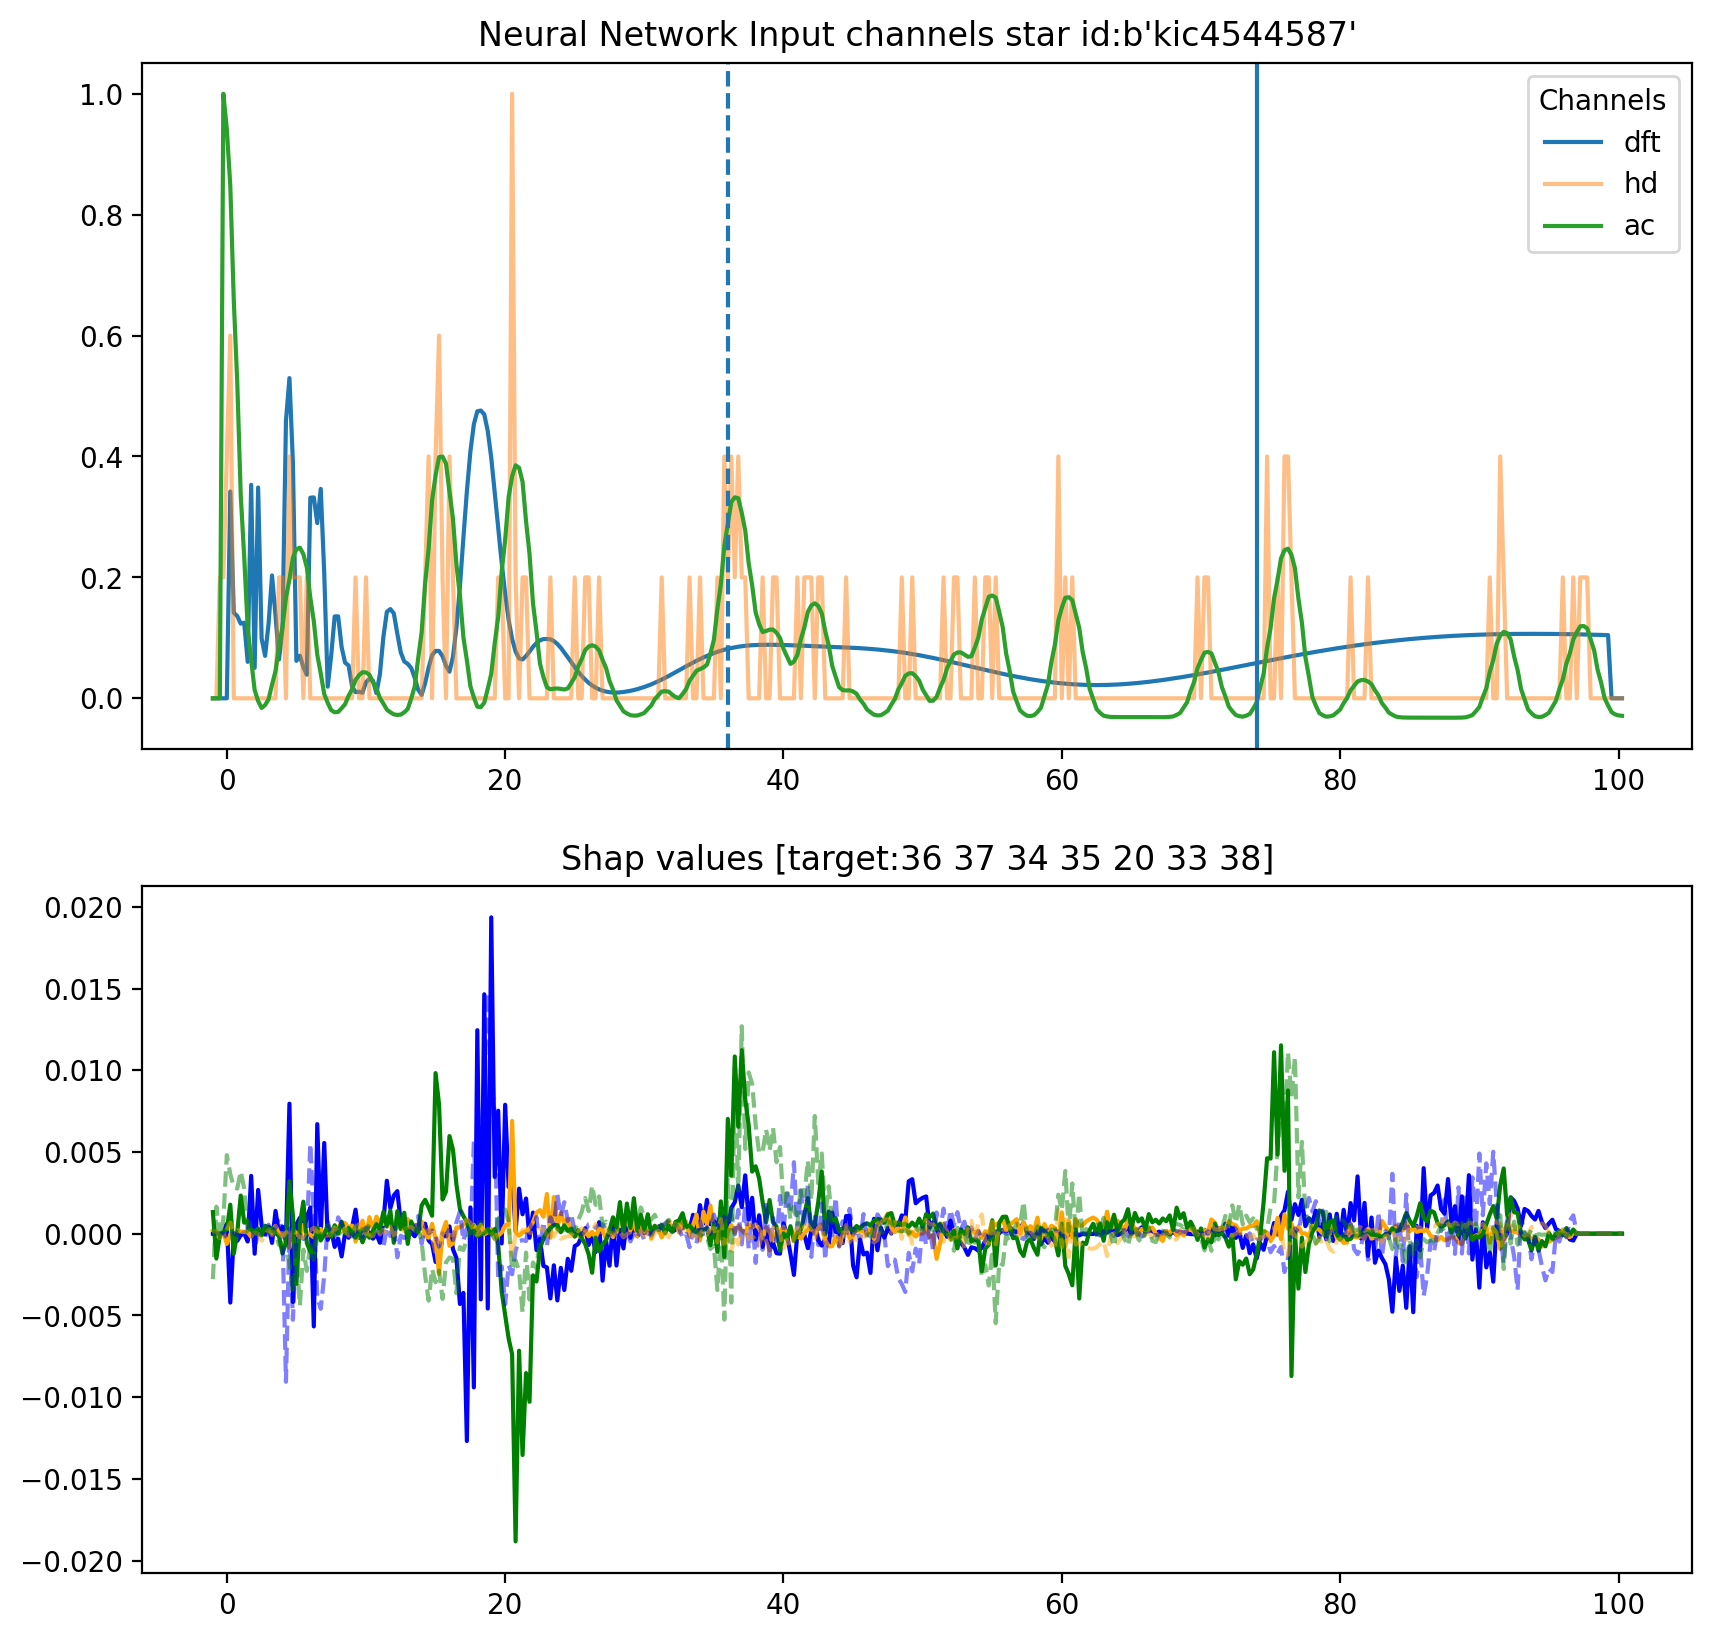

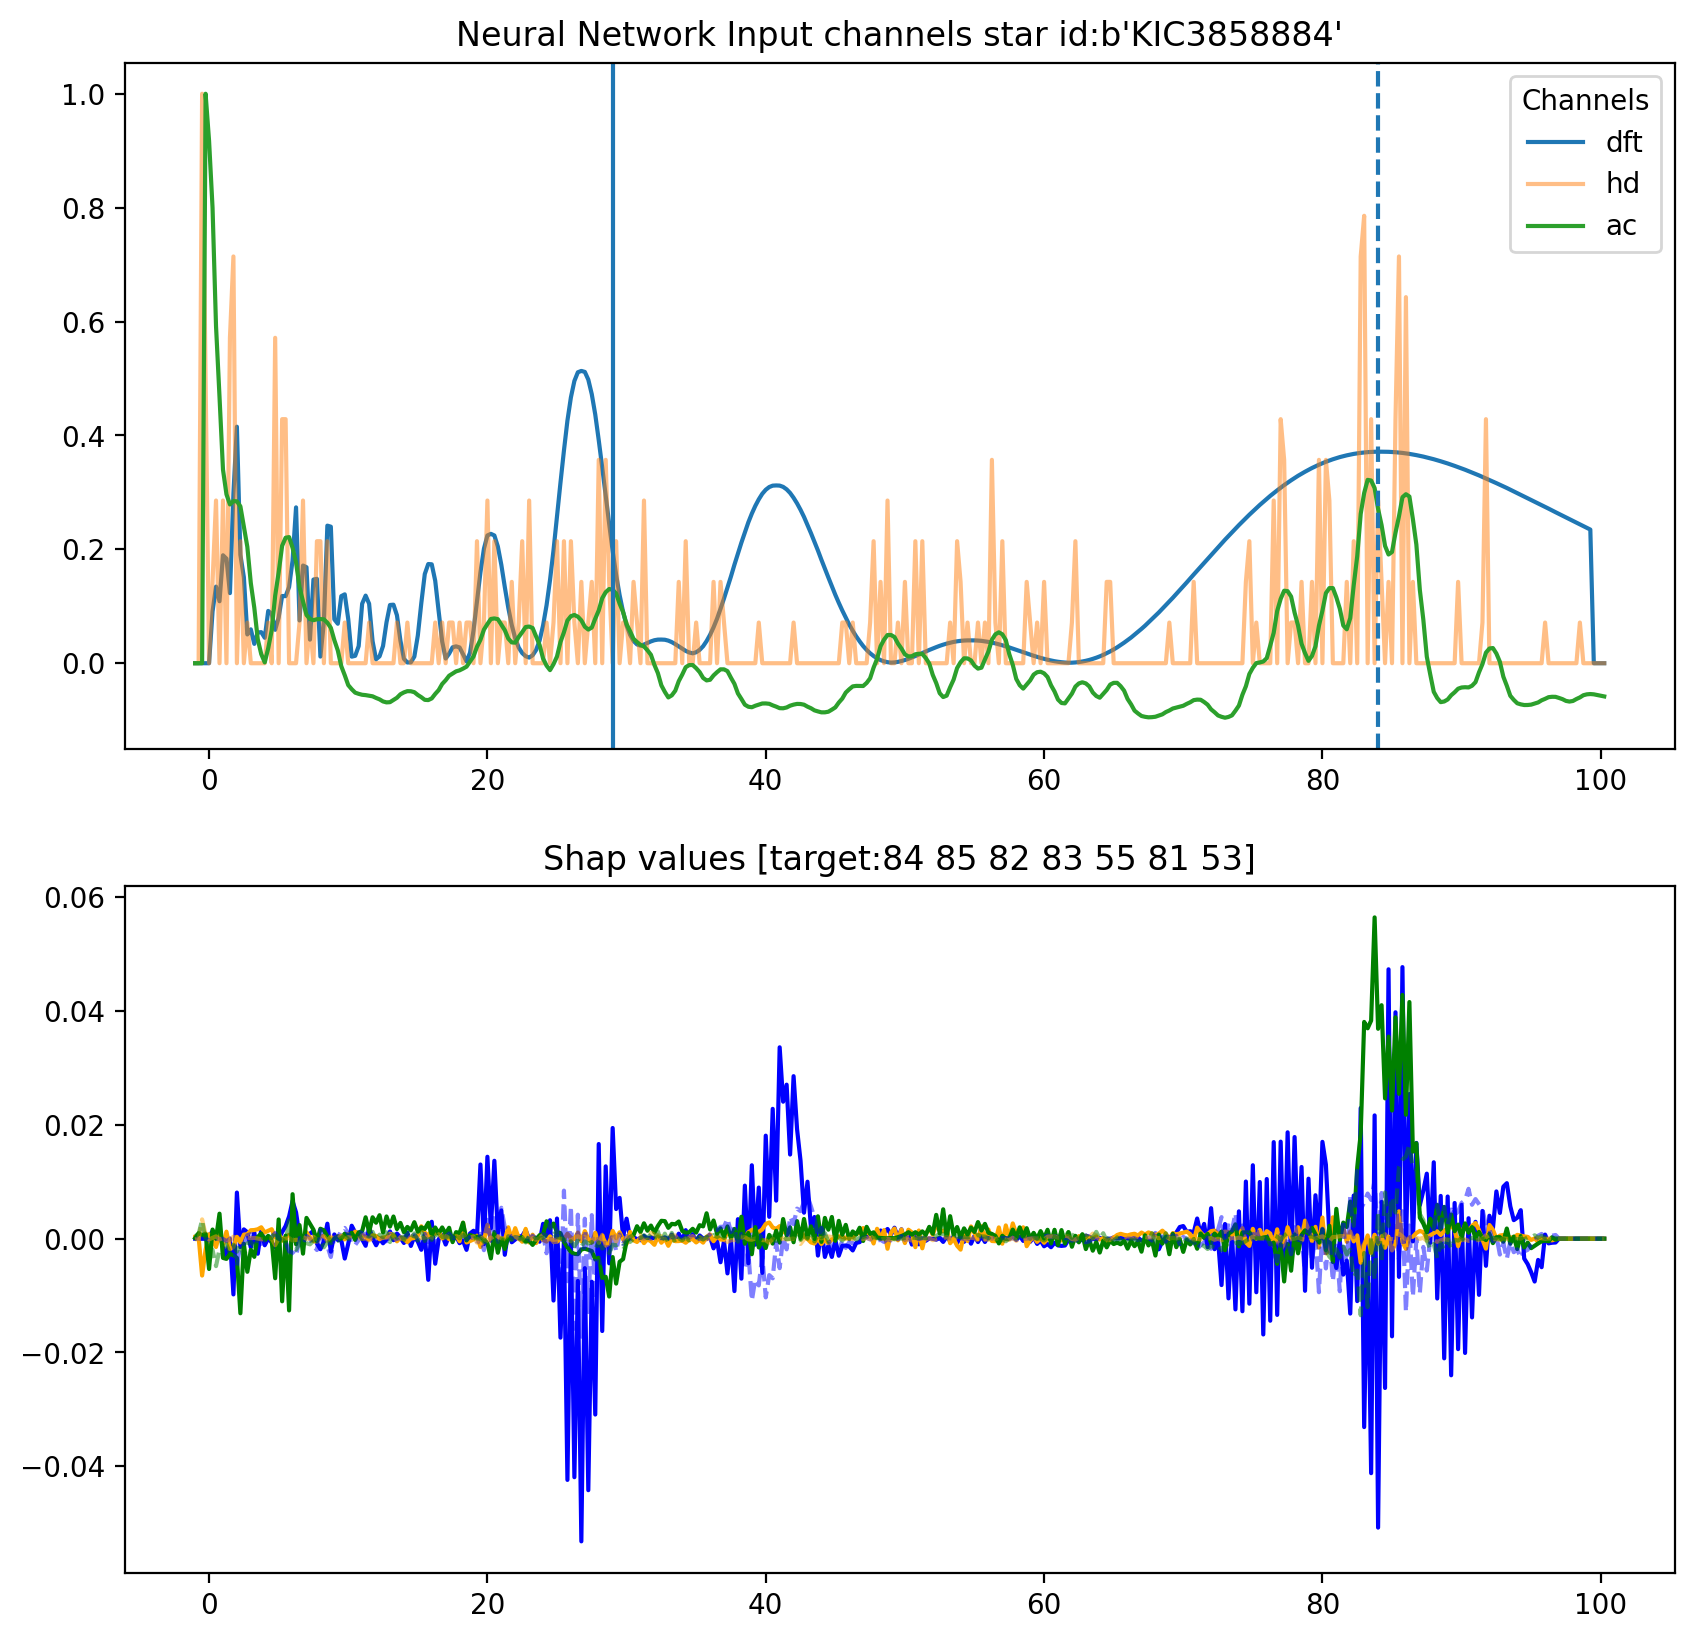

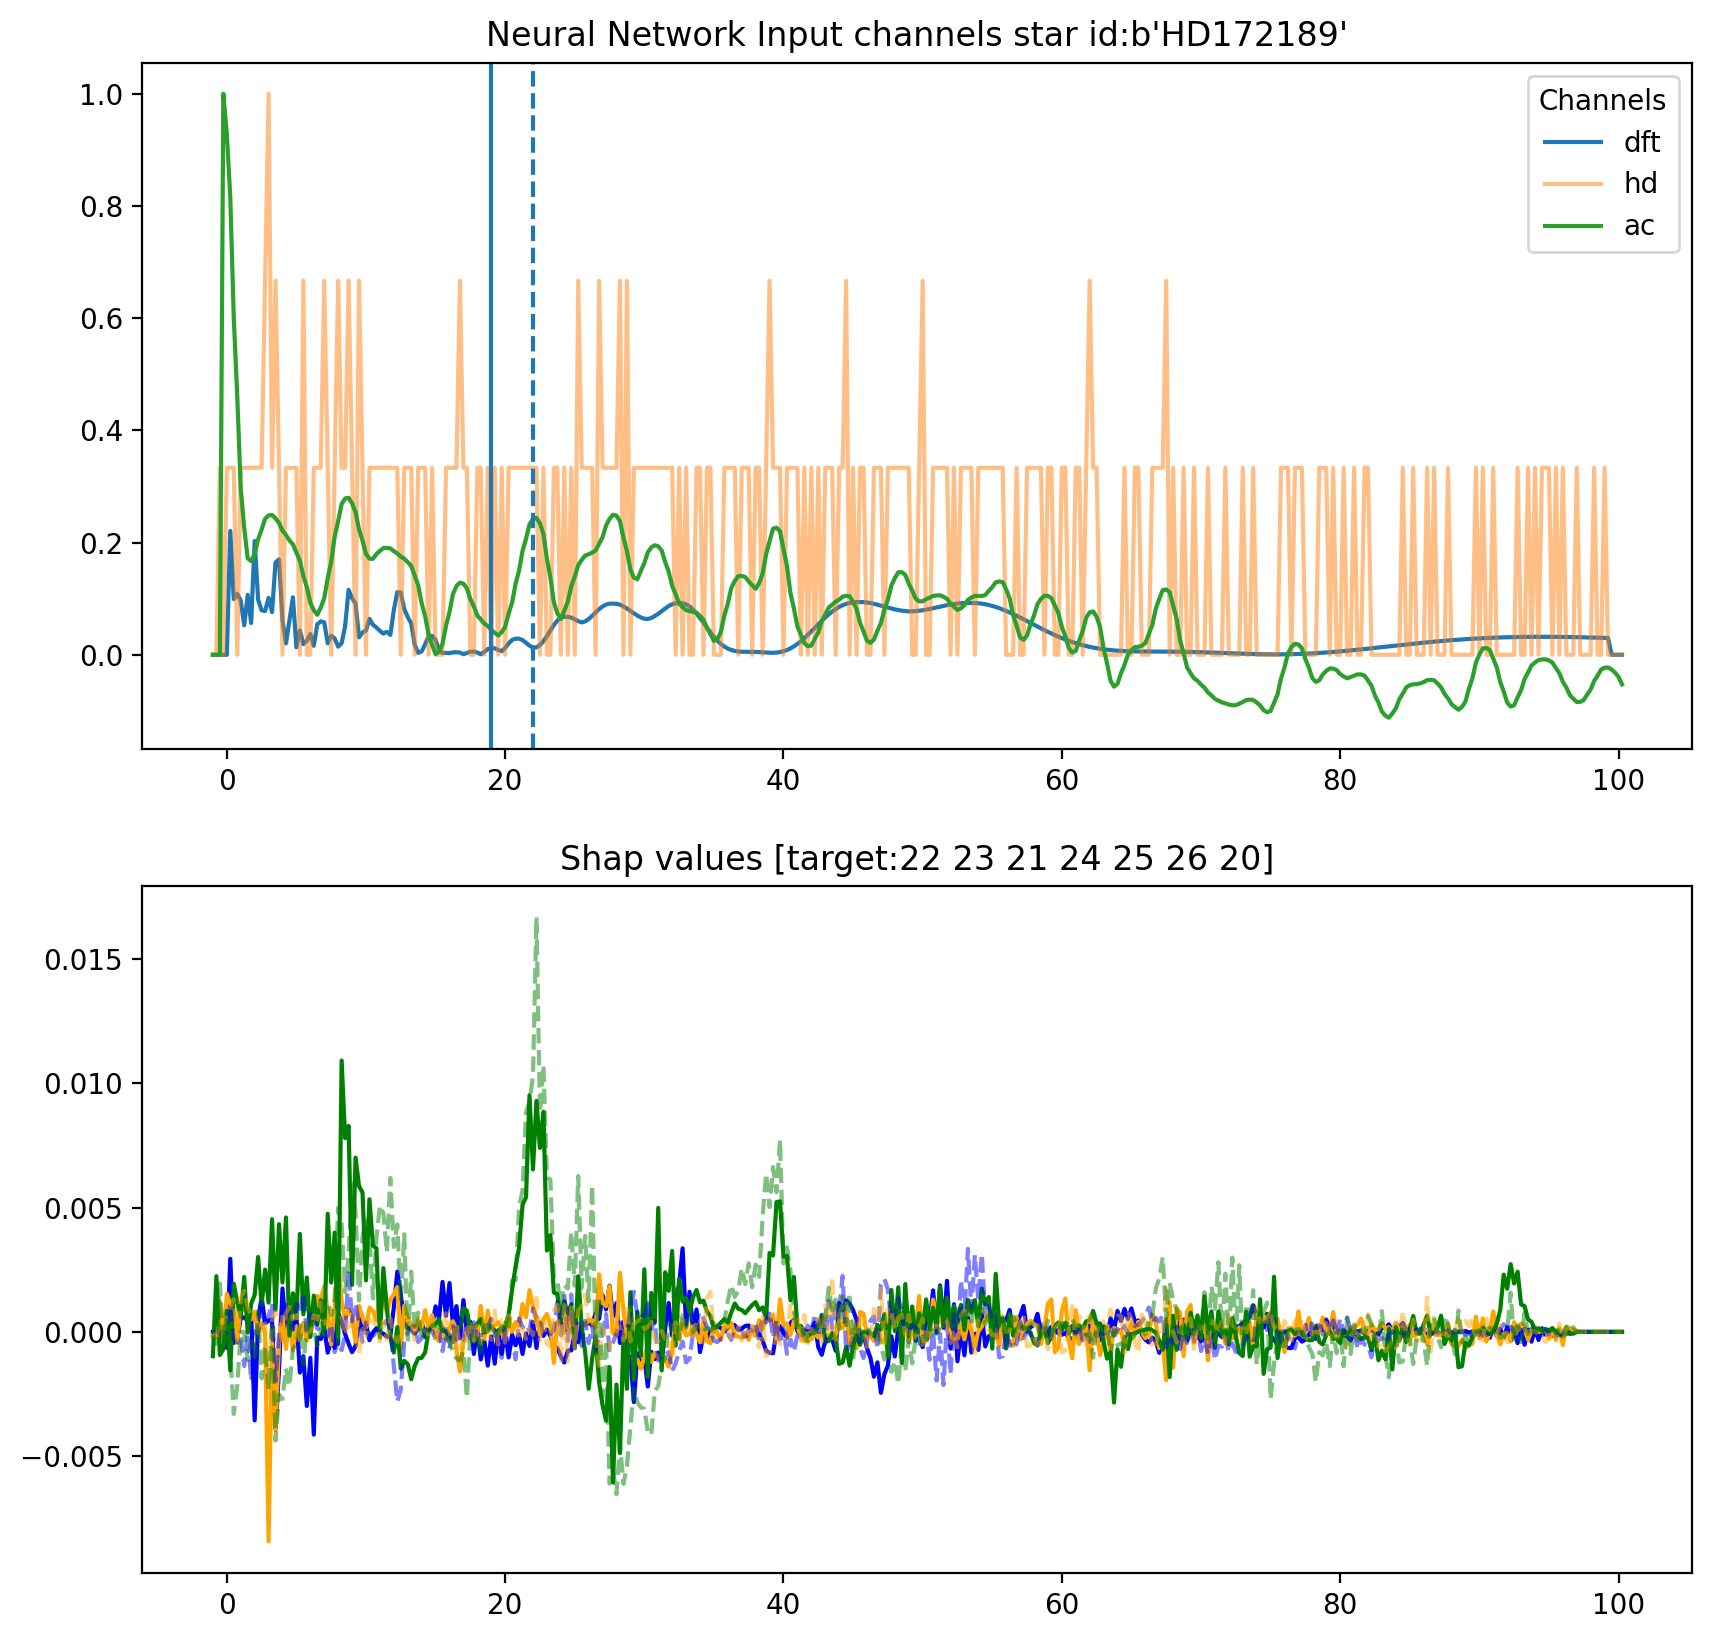

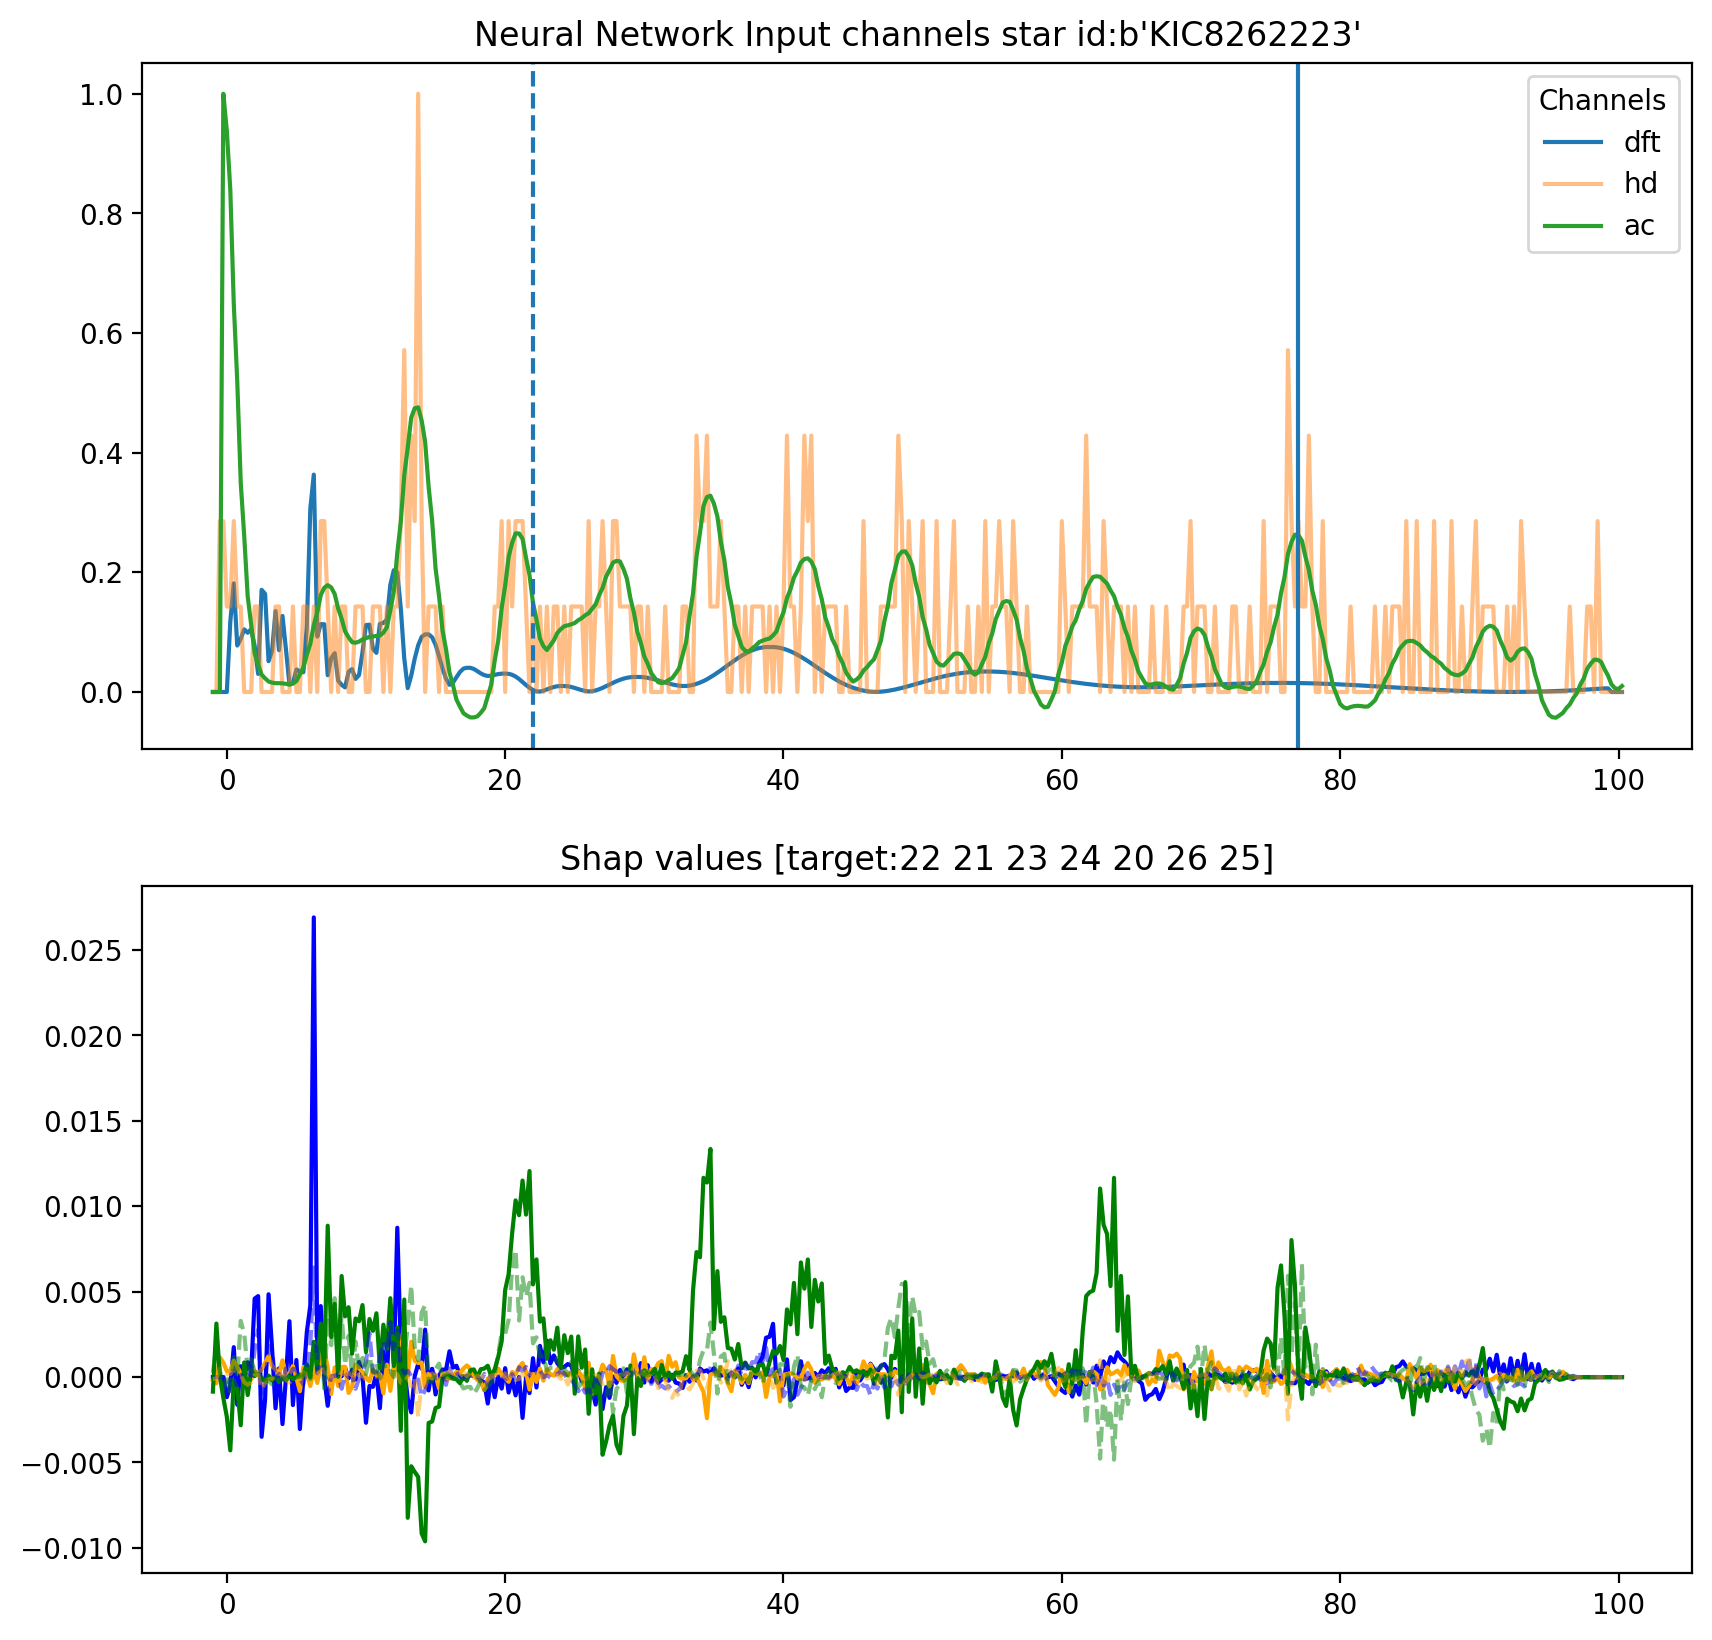

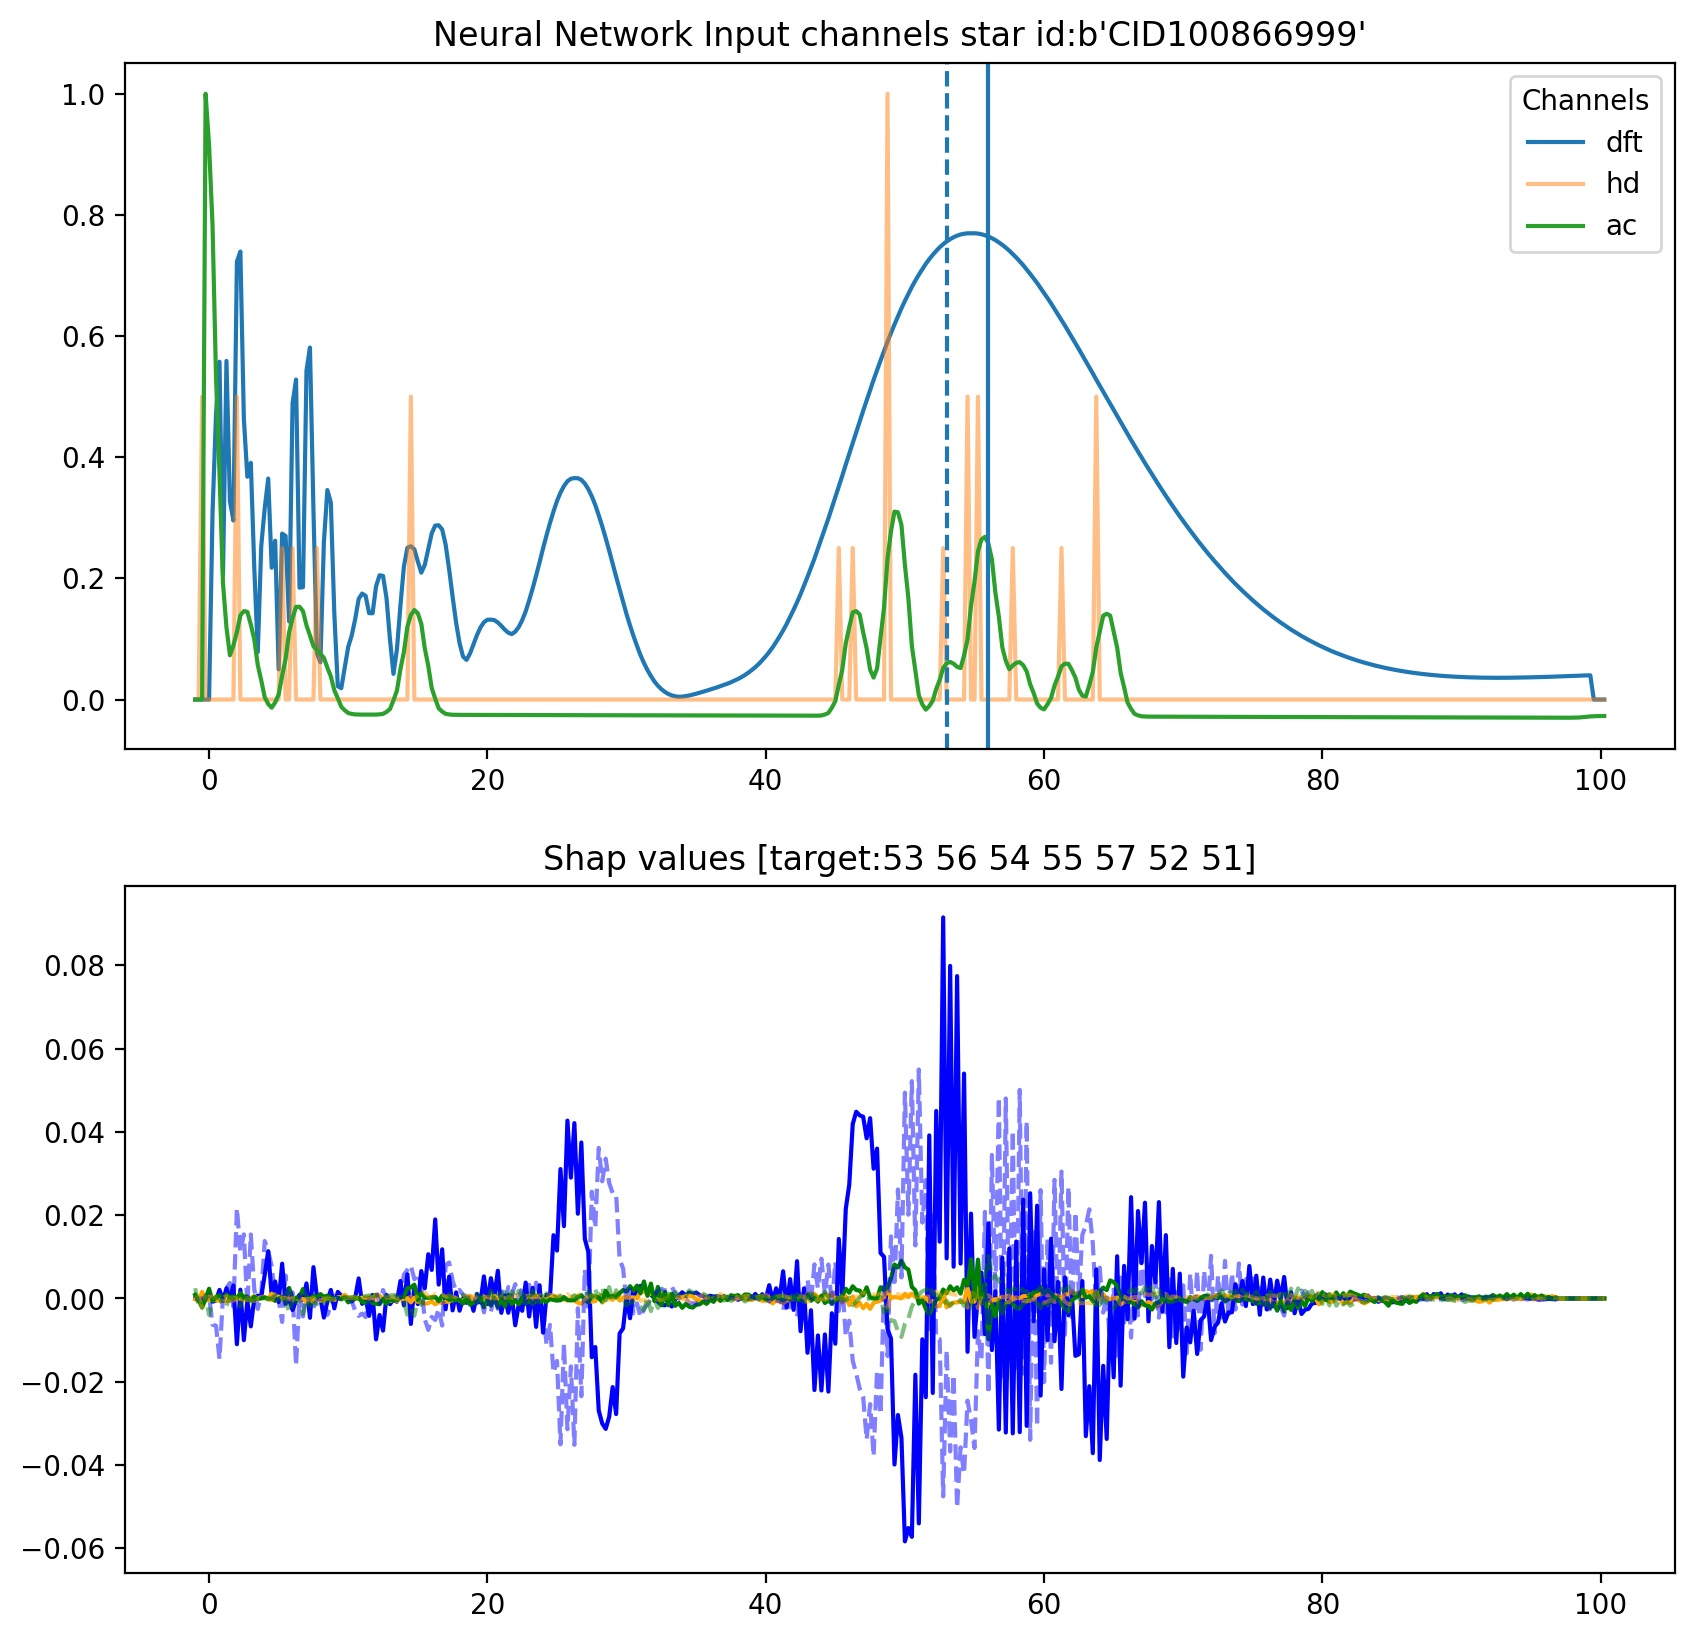

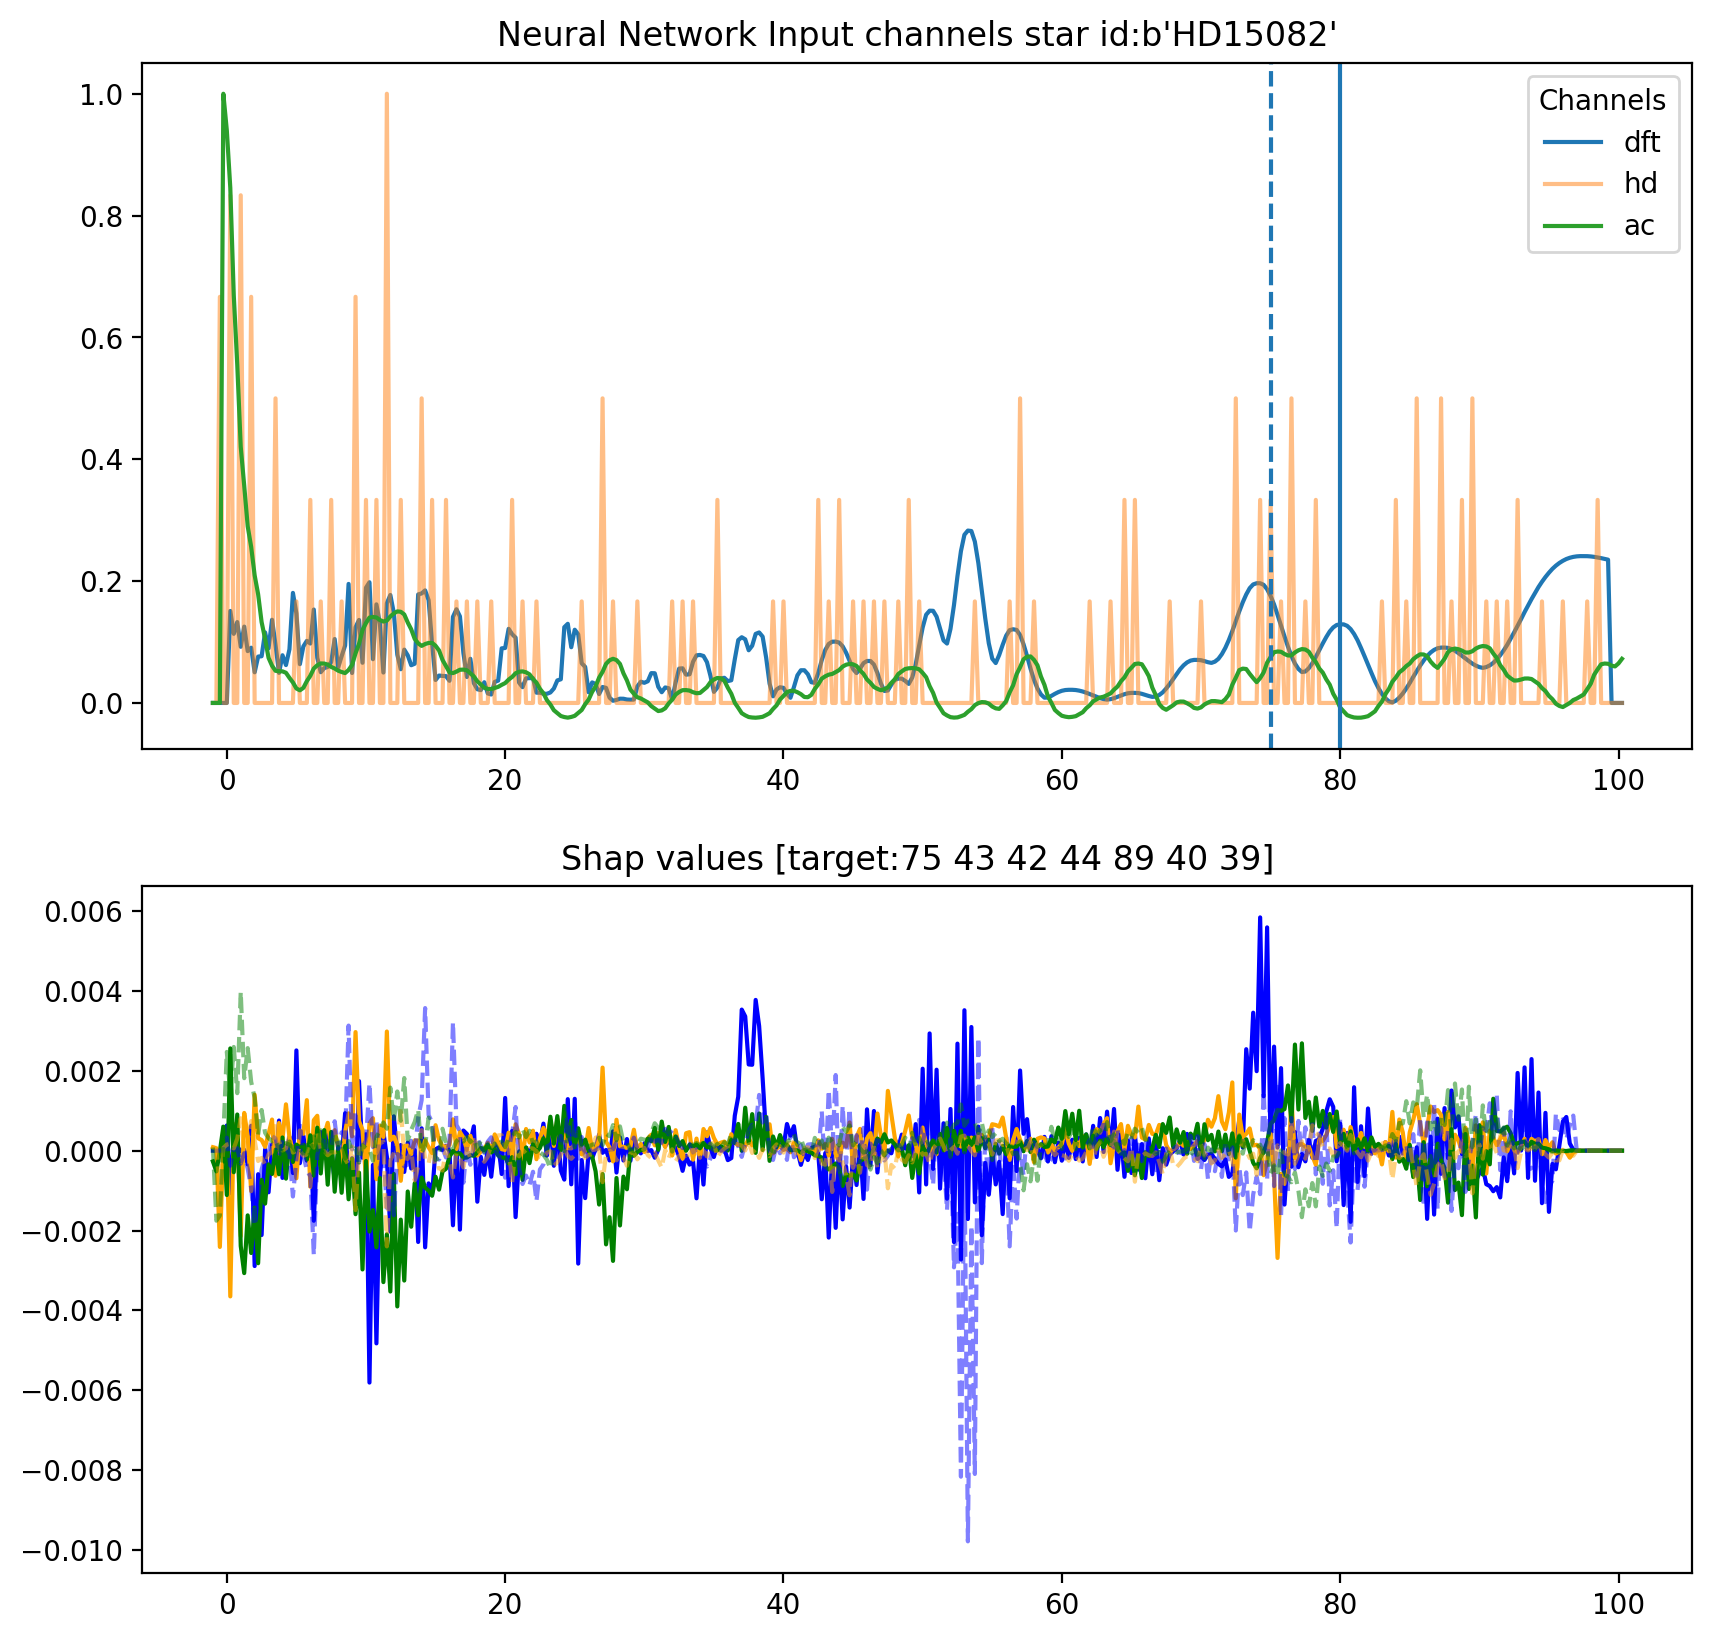

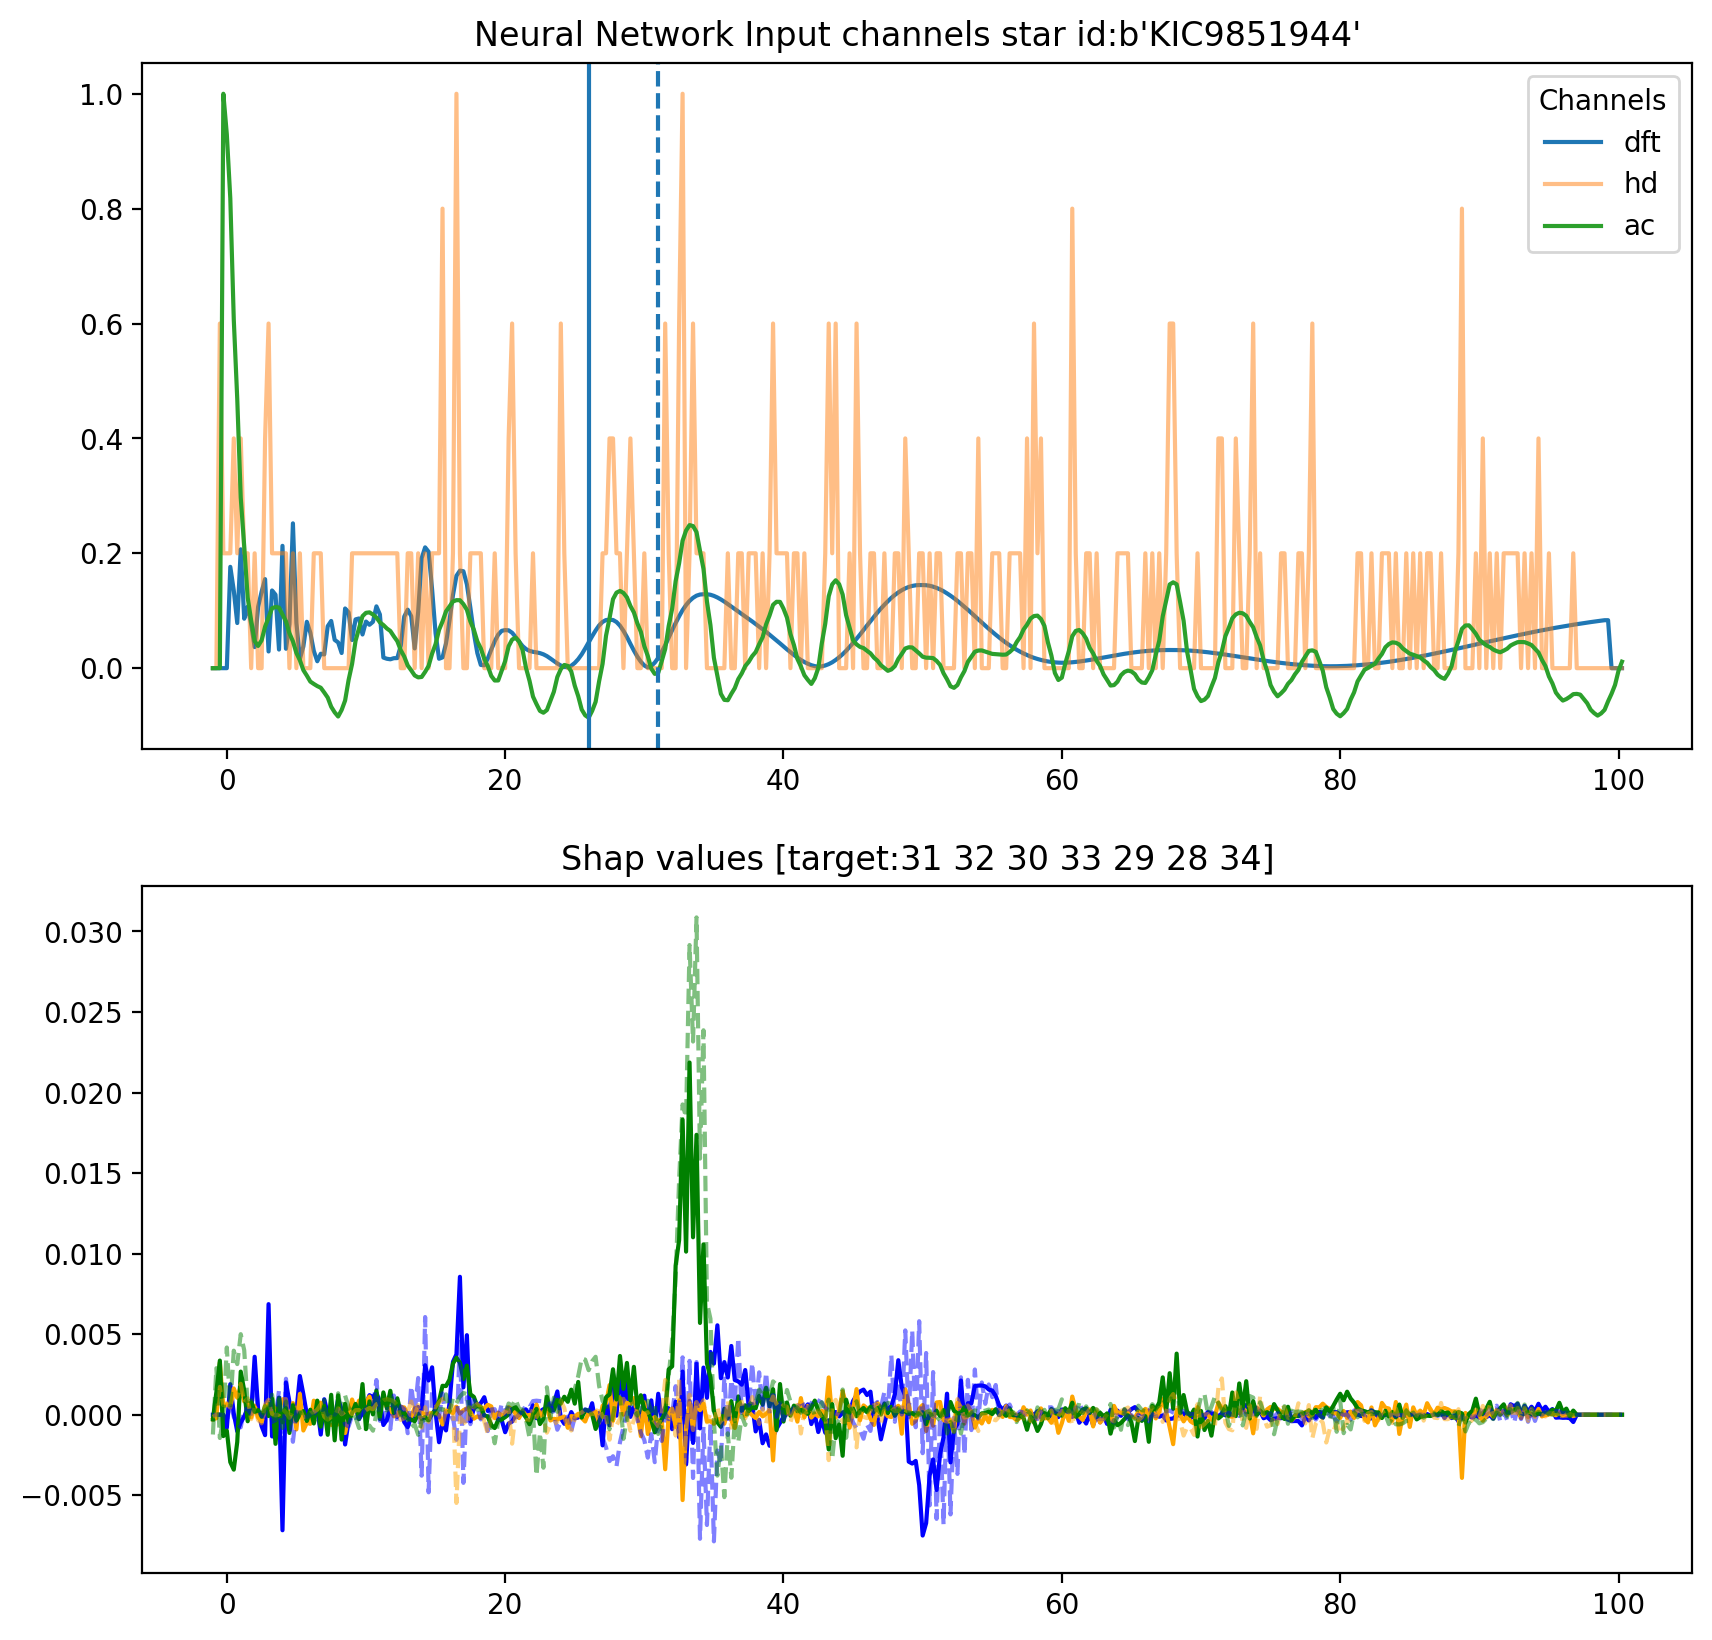

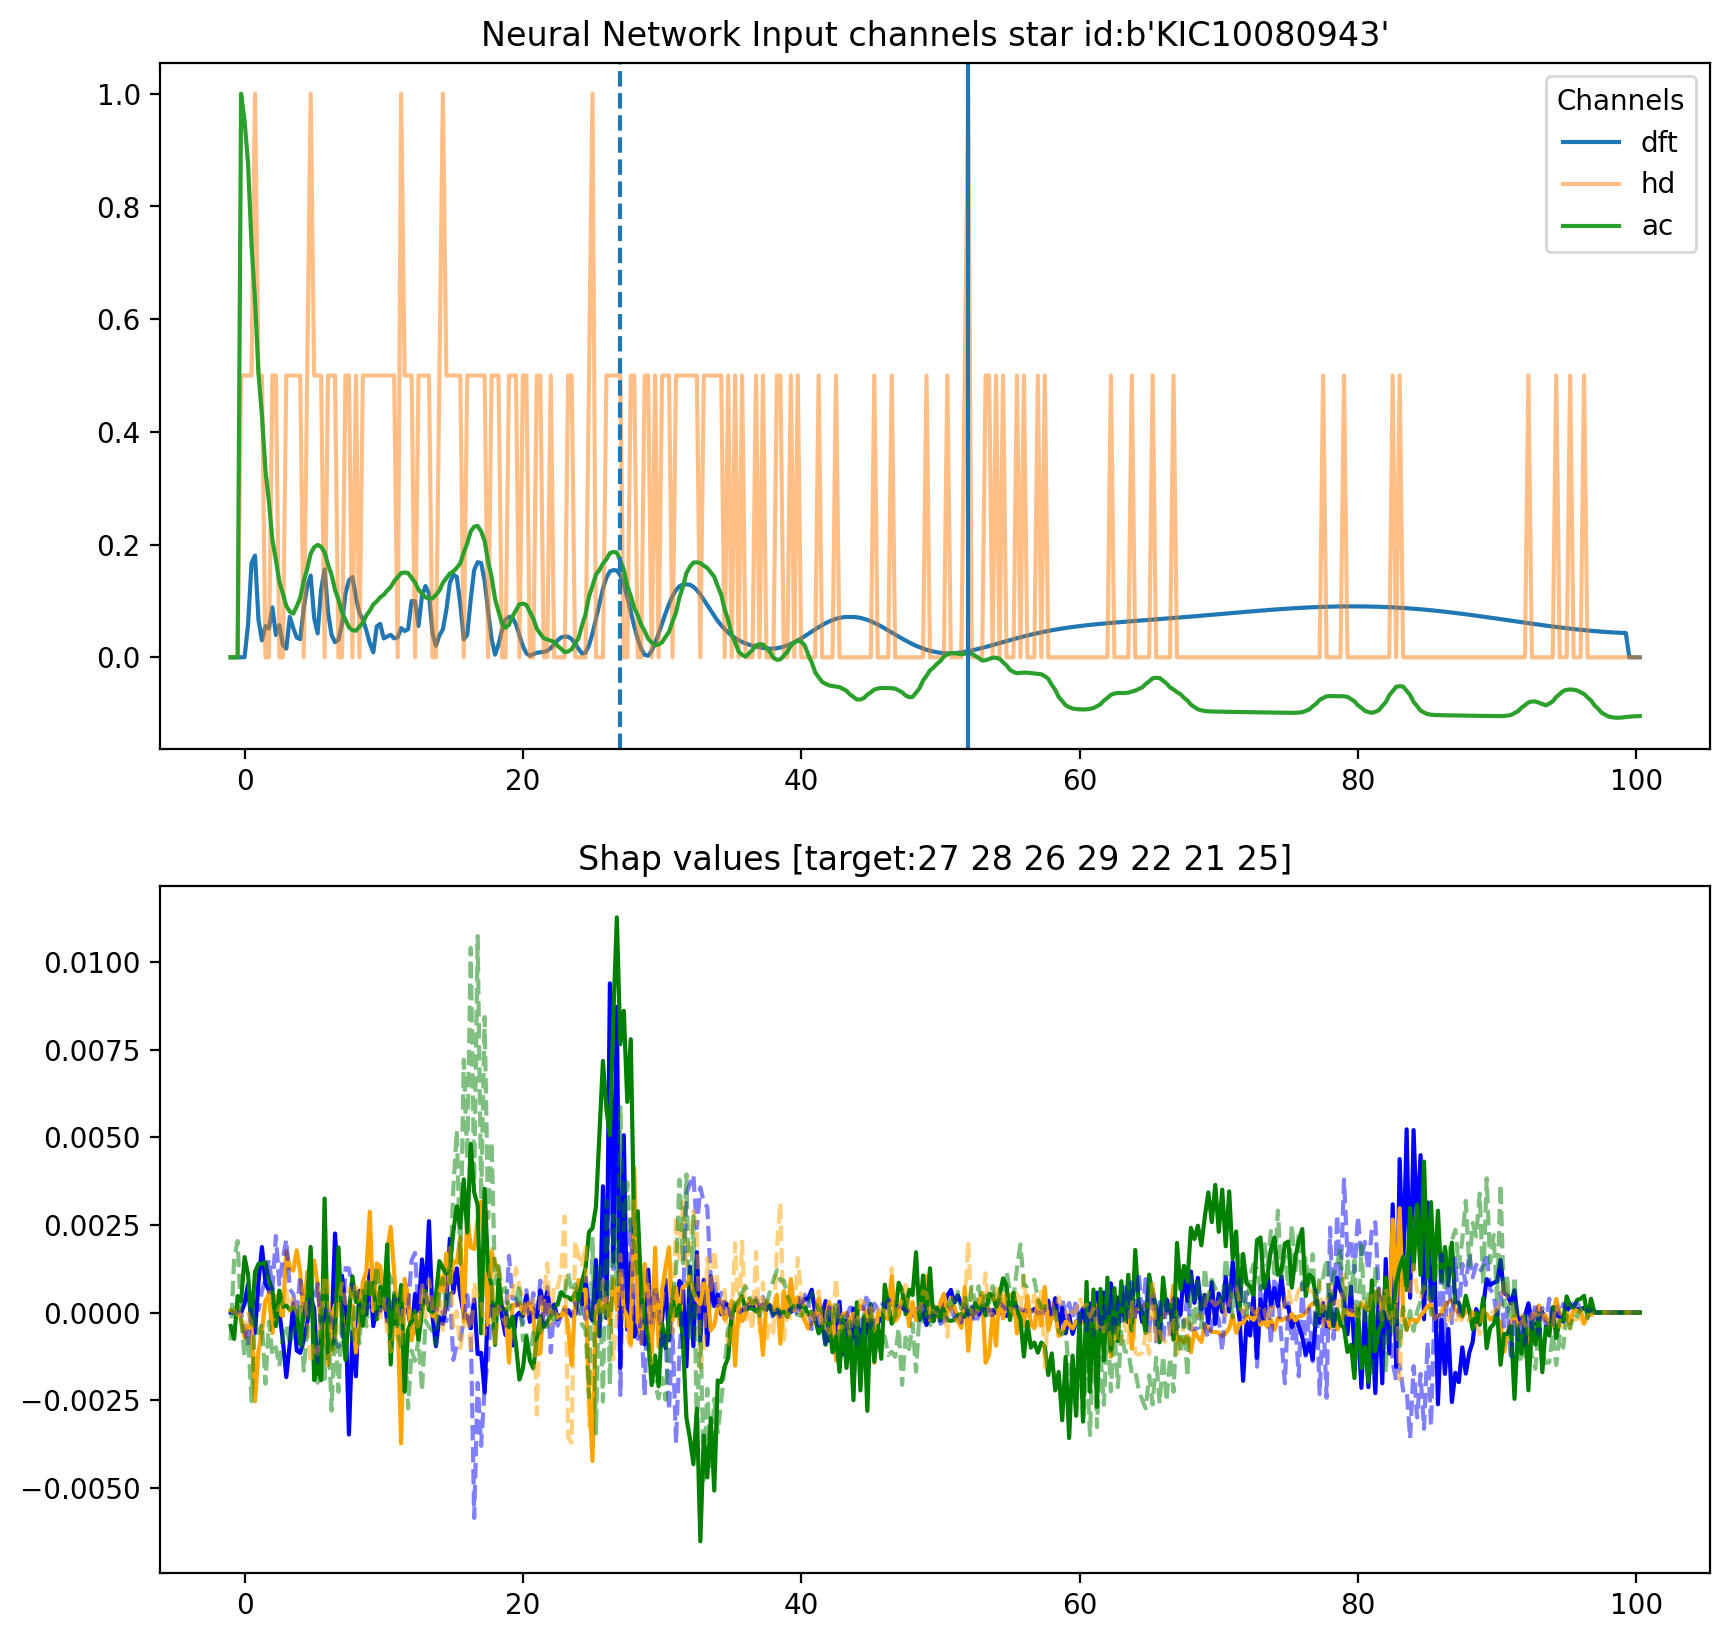

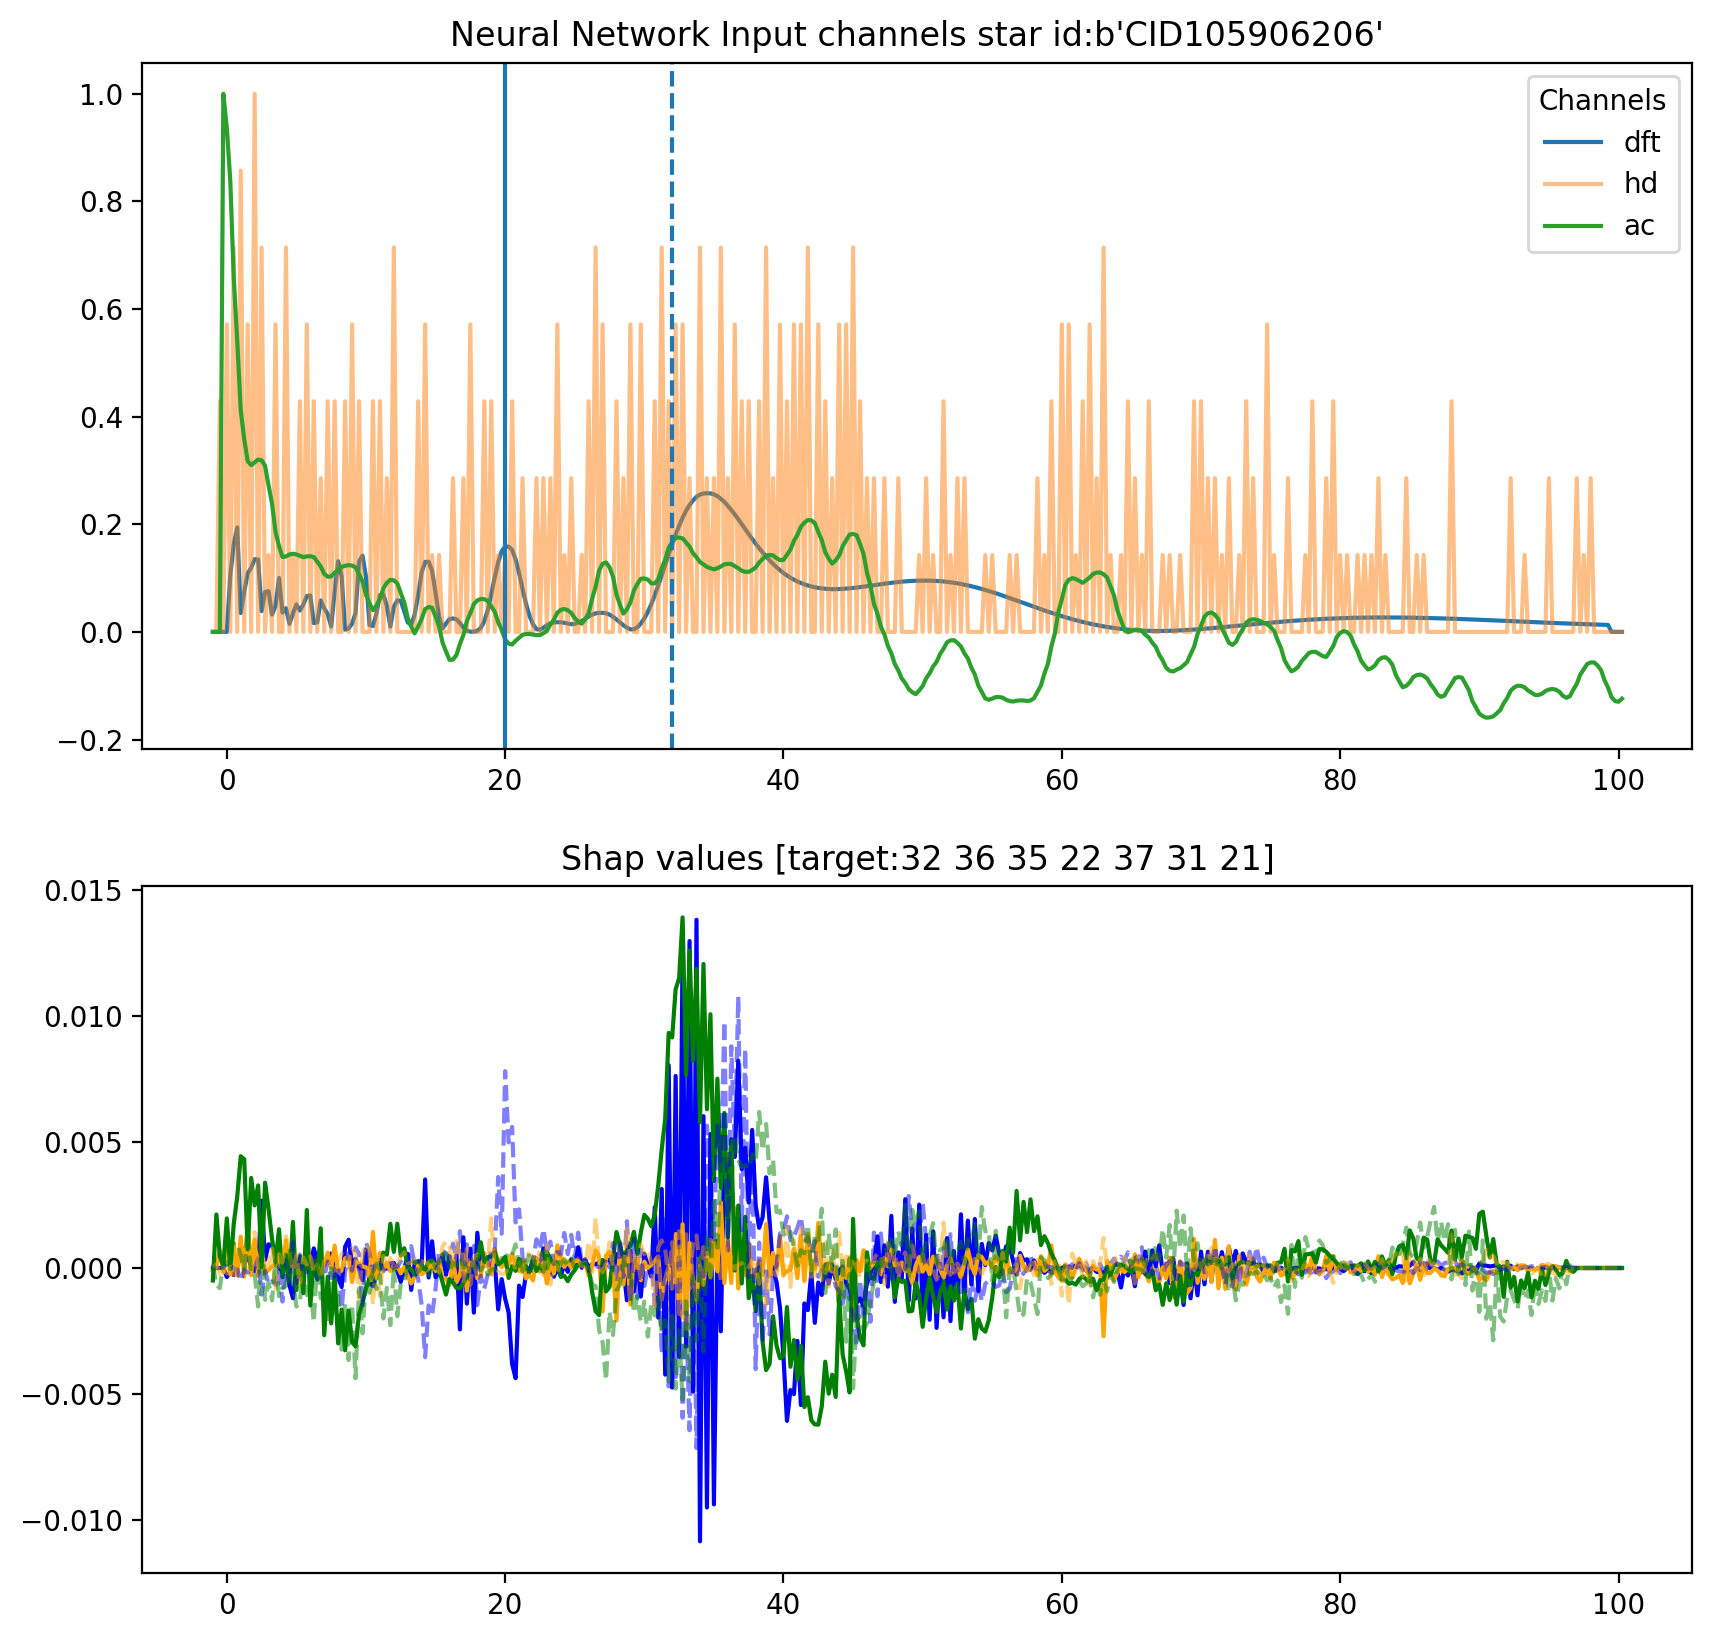

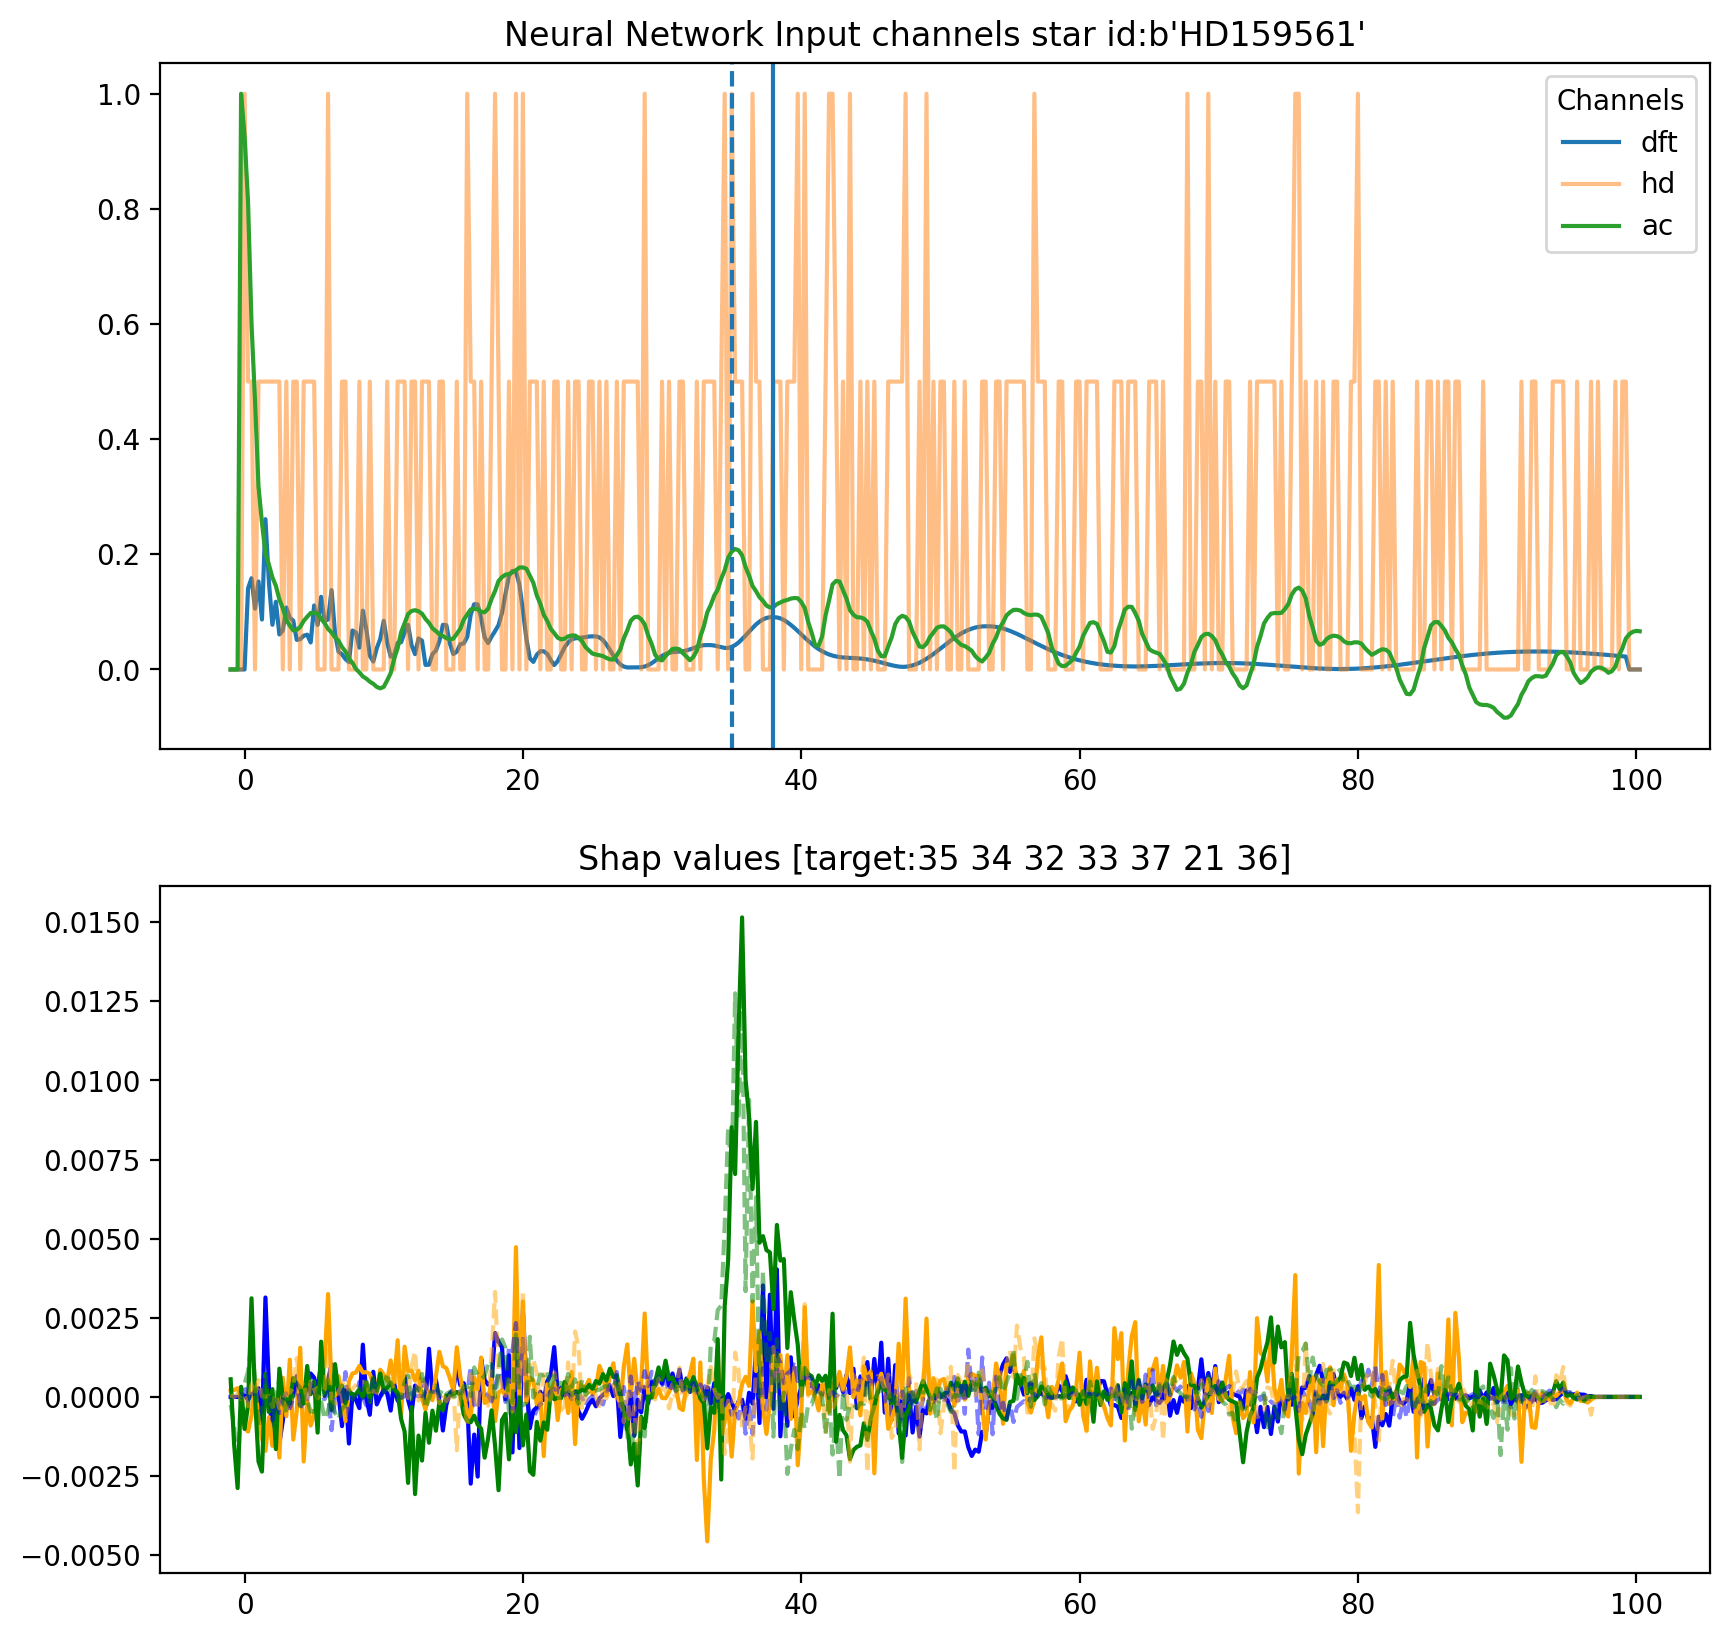

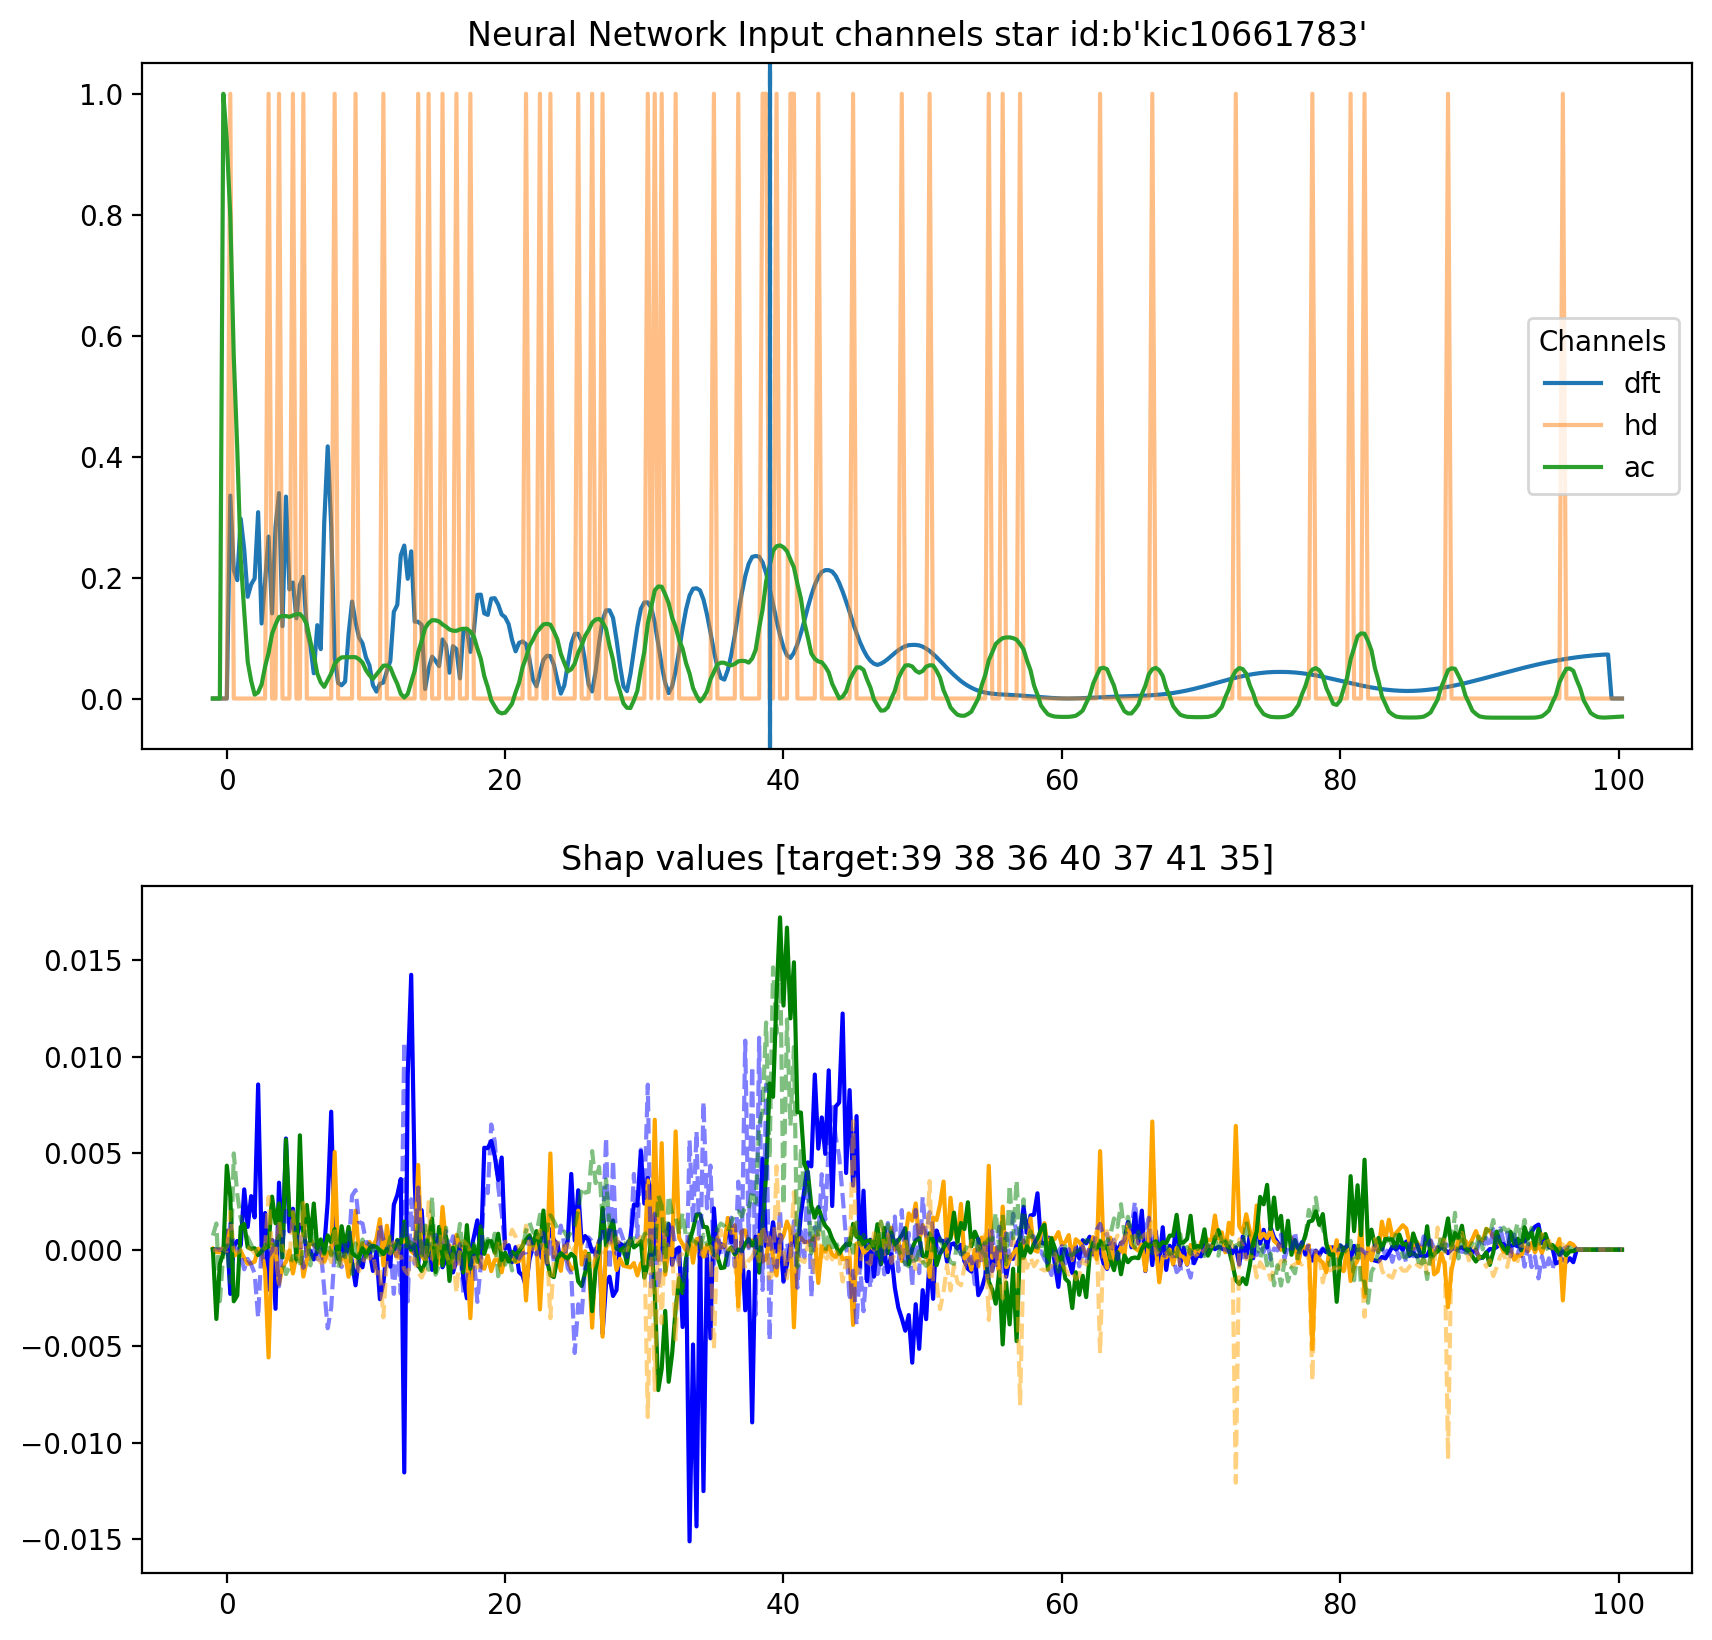

In [5]:
# Read datasets of preprocessed stars
df_ds = deltascuti()
df = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)
# Read star models (trainning) to calculate shap values
star_models = starmodels()
df_sm = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150)
_train_shap = np.asarray([line[0].numpy() for line in df_sm.take(10)])
_train_shap = _train_shap.reshape(
    (
        _train_shap.shape[0] * _train_shap.shape[1],
        _train_shap.shape[2],
        _train_shap.shape[3],
    )
)
# Load model
sepconv_mod = tf.keras.models.load_model("/tmp/sepconvnn_tmp_99")
sepconv_mod.summary()

x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100

for star in df.take(11):  # take the 11 ds stars
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    # Plot information about ds star
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), dpi=200)
    ax1.plot(x, star[1][0, :, 0].numpy(), label="dft")
    ax1.plot(x, star[1][0, :, 1].numpy(), alpha=0.5, label="hd")
    ax1.plot(x, star[1][0, :, 2].numpy(), label="ac")
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    ax1.axvline(x=target)
    ax1.axvline(x=sepconv_mod.predict_classes(star[1]), linestyle="--")
    # Calculate gradient explainers and shap values
    e = shap.GradientExplainer(
        sepconv_mod, _train_shap, batch_size=10, local_smoothing=0
    )
    shap_values, indexes = e.shap_values(
        star[1].numpy(), nsamples=100, ranked_outputs=10
    )
    print(indexes)
    # Plot shap
    ax2.plot(x, shap_values[0][0][:, [0]], label="dft", linestyle="solid", color="blue")
    ax2.plot(
        x, shap_values[0][0][:, [1]], label="hd", linestyle="solid", color="orange"
    )
    ax2.plot(x, shap_values[0][0][:, [2]], label="ac", linestyle="solid", color="green")
    ax2.plot(
        x,
        shap_values[1][0][:, [0]],
        label="dft",
        linestyle="--",
        color="blue",
        alpha=0.5,
    )
    ax2.plot(
        x,
        shap_values[1][0][:, [1]],
        label="hd",
        linestyle="--",
        color="orange",
        alpha=0.5,
    )
    ax2.plot(
        x,
        shap_values[1][0][:, [2]],
        label="ac",
        linestyle="--",
        color="green",
        alpha=0.5,
    )

    ax1.legend(title="Channels")
    ax1.title.set_text("Neural Network Input channels" + " star id:" + str(star[0].numpy()[0]))
    ax2.title.set_text(
        "Shap values"
        + " [target:"
        + str(indexes[0][0])
        + " "
        + str(indexes[0][1])
        + " "
        + str(indexes[0][2])
        + " "
        + str(indexes[0][3])
        + " "
        + str(indexes[0][4])
        + " "
        + str(indexes[0][5])
        + " "
        + str(indexes[0][6])
        + "]"
    )
    fig.show()

In [6]:
cid = None
for star in df.take(11):  # take the 11 ds stars
    print(str(star[0].numpy()[0]))
    if star[0].numpy()[0].decode("utf-8") == 'CID100866999':
        cid = star

b'KIC9851944'
b'KIC3858884'
b'HD159561'
b'kic4544587'
b'HD15082'
b'CID100866999'
b'KIC10080943'
b'KIC8262223'
b'CID105906206'
b'HD172189'
b'kic10661783'


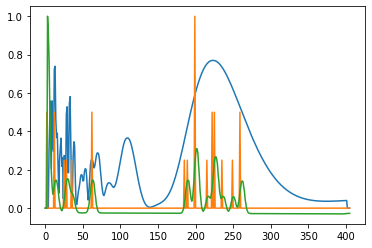

Instructions for updating:
Please use `model.predict()` instead.


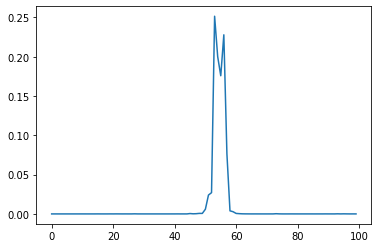

In [7]:
# Plot sample star
x = cid[1].numpy()

# Modify values
#x[0, 0:400, 0] = 0.5

plt.plot(x[0, :, 0])
plt.plot(x[0, :, 1])
plt.plot(x[0, :, 2])
plt.show()
plt.plot(sepconv_mod.predict_proba(x)[0][0:100])
plt.show()

## CoRoT 75 stars study

In [8]:
vrrhosun = 1.409
vrloggsun = 4.44

def getRhoFromDnu(Dnu, e_Dnu=0):
    """
    calculate Rho from Dnu estimating the error produced
    """
    rho_sun = 1.409
    dnu_sun = 134.8
    a = 1.501
    e_a = 0.096
    b = 2.0373
    e_b = 0.0405
    rho = (a * (Dnu / dnu_sun) ** b) * rho_sun
    e_rho = rho * np.sqrt(
        (e_a / a) ** 2
        + (b * e_Dnu / (Dnu * dnu_sun)) ** 2
        + (np.log10(Dnu / dnu_sun) * e_b) ** 2
    )
    return {"rho": rho, "error": e_rho}


def get_radio_from_rho(rho, e_rho):
    """
    calculate radio from rho, estimating max and min values
    """
    R_min = (1.5 / (rho + e_rho) / vrrhosun) ** (1 / 3)
    R_max = (3 / (rho - e_rho) / vrrhosun) ** (1 / 3)
    return {"r_min": R_min, "r_max": R_max}


def get_logg_from_radio(R_max, R_min):
    """
    calculate logg from radio estimating max and min values
    """
    logg_min = np.log10(1.5 / R_max ** 2) + vrloggsun
    logg_max = np.log10(3 / R_min ** 2) + vrloggsun
    return {"logg_min": logg_min, "logg_max": logg_max}

# Test
rhos = getRhoFromDnu(21, 4)
radios = get_radio_from_rho(rhos["rho"], rhos["error"])
loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
loggs_average

3.767547179252057

CoRoT ID: 102670461
Shap values (sorted): [[23 22 21 24 20 25 28 26 27 29]]
Logg from Hareter: 3.575
Avg logg from NN: [3.82122274]
Confidence logg from NN: {'logg_min': array([3.54972441]), 'logg_max': array([4.09272107])}
Logg from Hareter is inside NN confidence=: [ True]


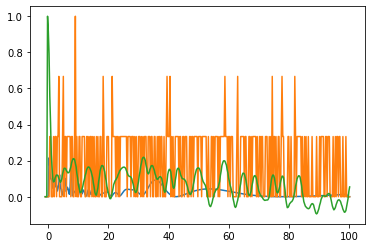

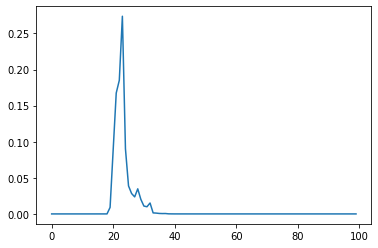

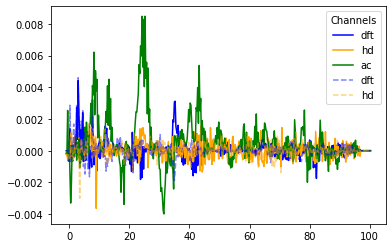



CoRoT ID: 102686153
Shap values (sorted): [[42 43 44 45 33 41 32 27 28 31]]
Logg from Hareter: 3.525
Avg logg from NN: [4.1765014]
Confidence logg from NN: {'logg_min': array([3.90616278]), 'logg_max': array([4.44684001])}
Logg from Hareter is inside NN confidence=: [False]


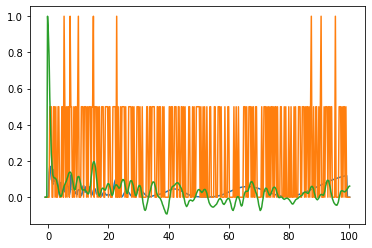

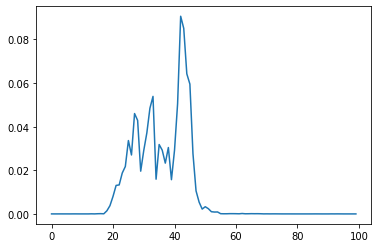

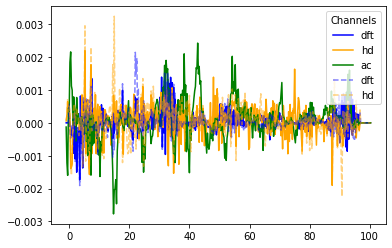



CoRoT ID: 102733521
Shap values (sorted): [[22 32 21 23 24 20 28 27 25 33]]
Logg from Hareter: 3.625
Avg logg from NN: [3.79499522]
Confidence logg from NN: {'logg_min': array([3.52339513]), 'logg_max': array([4.0665953])}
Logg from Hareter is inside NN confidence=: [ True]


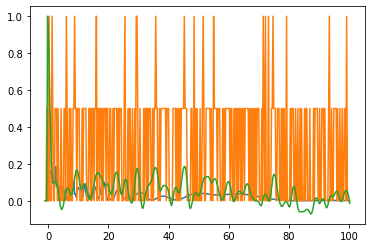

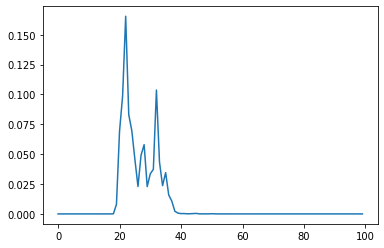

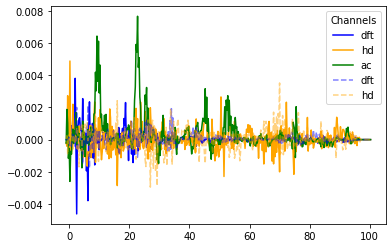



CoRoT ID: 102673795
Shap values (sorted): [[46 47 48 45 44 49 43 50 42 41]]
Logg from Hareter: 3.75
Avg logg from NN: [4.23017112]
Confidence logg from NN: {'logg_min': array([3.95997027]), 'logg_max': array([4.50037197])}
Logg from Hareter is inside NN confidence=: [False]


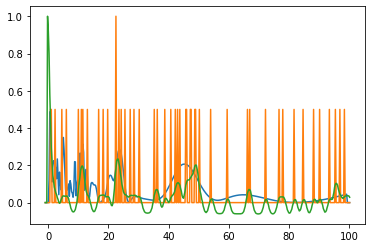

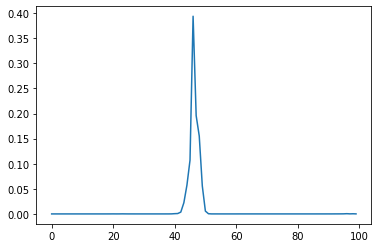

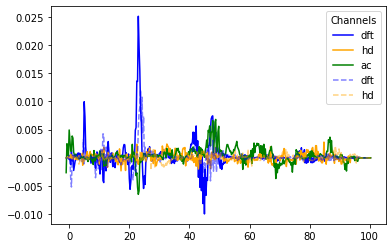



CoRoT ID: 102634888
Shap values (sorted): [[28 27 29 30 31 20 22 32 26 19]]
Logg from Hareter: 4.0
Avg logg from NN: [3.93728393]
Confidence logg from NN: {'logg_min': array([3.66621005]), 'logg_max': array([4.2083578])}
Logg from Hareter is inside NN confidence=: [ True]


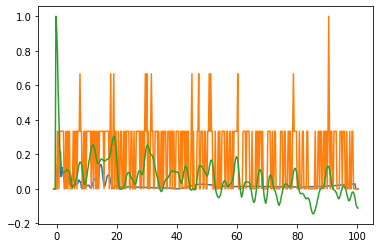

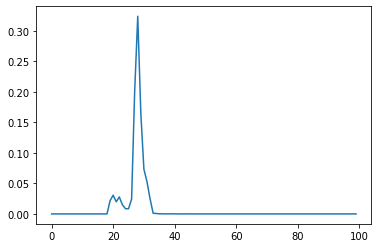

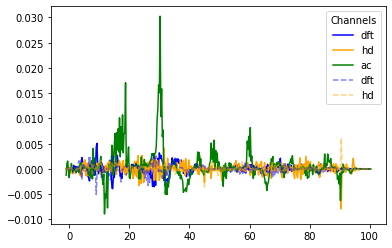



CoRoT ID: 102702932
Shap values (sorted): [[22 21 23 20 24 25 27 26 28 19]]
Logg from Hareter: 3.35
Avg logg from NN: [3.79499522]
Confidence logg from NN: {'logg_min': array([3.52339513]), 'logg_max': array([4.0665953])}
Logg from Hareter is inside NN confidence=: [False]


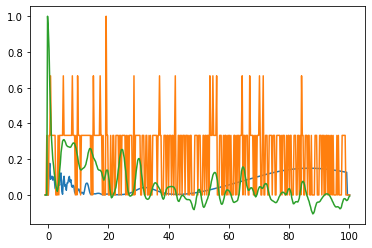

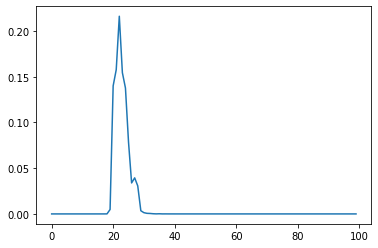

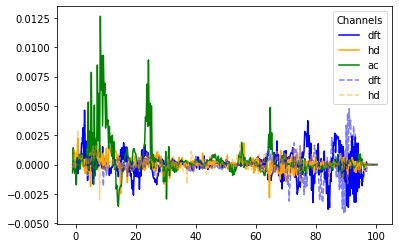



CoRoT ID: 102589546
Shap values (sorted): [[22 28 32 31 27 35 36 23 26 21]]
Logg from Hareter: 3.7
Avg logg from NN: [3.79499522]
Confidence logg from NN: {'logg_min': array([3.52339513]), 'logg_max': array([4.0665953])}
Logg from Hareter is inside NN confidence=: [ True]


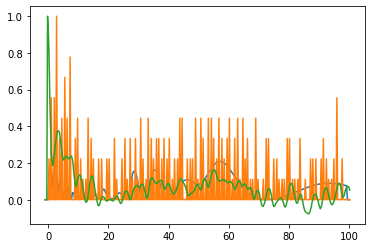

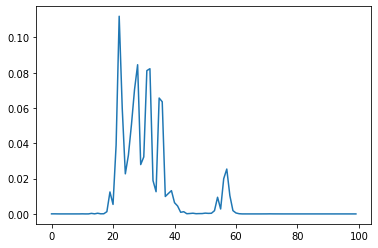

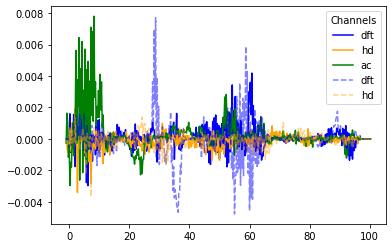



CoRoT ID: 102623864
Shap values (sorted): [[54 55 53 52 56 57 36 51 37 38]]
Logg from Hareter: 4.0
Avg logg from NN: [4.32476506]
Confidence logg from NN: {'logg_min': array([4.05478163]), 'logg_max': array([4.59474849])}
Logg from Hareter is inside NN confidence=: [False]


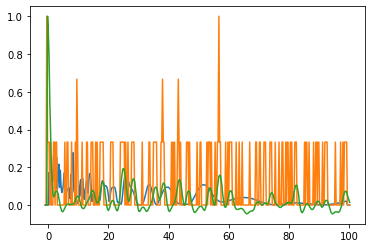

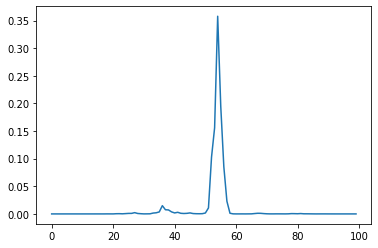

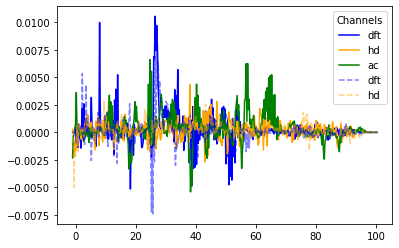



CoRoT ID: 102622725
Shap values (sorted): [[63 61 64 62 48 40 49 50 41 46]]
Logg from Hareter: 4.3
Avg logg from NN: [4.41570386]
Confidence logg from NN: {'logg_min': array([4.14589811]), 'logg_max': array([4.68550961])}
Logg from Hareter is inside NN confidence=: [ True]


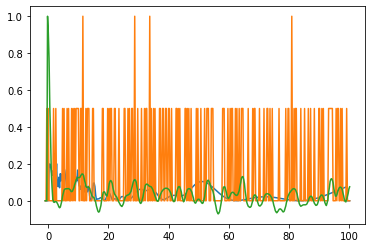

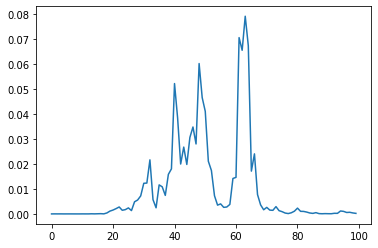

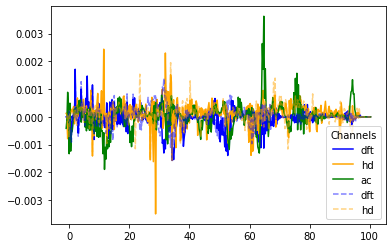



CoRoT ID: 102675756
Shap values (sorted): [[20 23 21 22 24 25 19 26 28 27]]
Logg from Hareter: 3.175
Avg logg from NN: [3.73875947]
Confidence logg from NN: {'logg_min': array([3.46693415]), 'logg_max': array([4.0105848])}
Logg from Hareter is inside NN confidence=: [False]


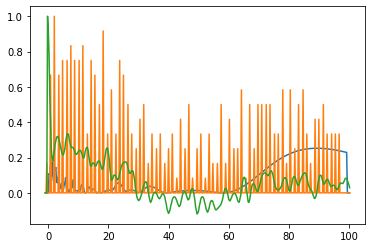

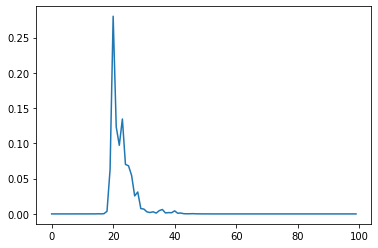

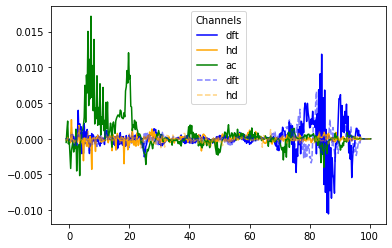

Counter({True: 38, False: 37})

In [9]:
# Read datasets of preprocessed stars
df_cor = corot()
dfcor = df_cor.load("../../astronn/data/corot/preprocessed/*.log", batch_size=1)

count = 0
aux = []
_x = []
_y = []
_l = [] #luminosity
for star in dfcor.take(75):  # take the 75 corot stars
    # Star channels info
    x_star = star[1].numpy()
    # Star logg from data
    logg_data = star[2][0].numpy()
    l = star[3][0].numpy()
    _l.append(l)

    # Dnu NN inference
    dnu_hat = sepconv_mod.predict_classes(star[1])
    
    # Calculate logg from Dnu infered by the NN
    rhos = getRhoFromDnu(dnu_hat, 4)
    radios = get_radio_from_rho(rhos["rho"], rhos["error"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
    # Get central point of logg confidence
    loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2

    # Append data for posterior analysis
    _x.append(logg_data)
    _y.append(loggs_average[0])

    # Flag to point out if logg from data is inside the confidence interval
    flag = (
        logg_data <= loggs_condifence["logg_max"]
        and logg_data >= loggs_condifence["logg_min"]
    )
    aux.append(flag) # save

    # Plot graphs and info (debug)
    if True and count < 10:
        # Calculate gradient explainers and shap values
        e = shap.GradientExplainer(
            sepconv_mod, _train_shap, batch_size=10, local_smoothing=0
        )
        shap_values, indexes = e.shap_values(
            star[1].numpy(), nsamples=100, ranked_outputs=10
        )

        # Log info
        print("CoRoT ID:",star[0].numpy()[0].decode("utf-8"))
        print("Shap values (sorted):",indexes)
        print("Logg from Hareter:",logg_data)
        print("Avg logg from NN:",loggs_average)
        print("Confidence logg from NN:",loggs_condifence)
        print("Logg from Hareter is inside NN confidence=:",flag)

        # Plot star
        x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100
        plt.plot(x, x_star[0, :, 0])
        plt.plot(x, x_star[0, :, 1])
        plt.plot(x, x_star[0, :, 2])
        plt.show()
        plt.plot(sepconv_mod.predict_proba(x_star)[0][0:100])
        plt.show()

        # Plot shap
        
        plt.plot(x, shap_values[0][0][:, [0]], label="dft", linestyle="solid", color="blue")
        plt.plot(
            x, shap_values[0][0][:, [1]], label="hd", linestyle="solid", color="orange"
        )
        plt.plot(x, shap_values[0][0][:, [2]], label="ac", linestyle="solid", color="green")
        plt.plot(
            x,
            shap_values[1][0][:, [0]],
            label="dft",
            linestyle="--",
            color="blue",
            alpha=0.5,
        )
        plt.plot(
            x,
            shap_values[1][0][:, [1]],
            label="hd",
            linestyle="--",
            color="orange",
            alpha=0.5,
        )
        ax2.plot(
            x,
            shap_values[1][0][:, [2]],
            label="ac",
            linestyle="--",
            color="green",
            alpha=0.5,
        )

        plt.legend(title="Channels")
        plt.show()
        print("\n")

    count += 1
# Compatible cases numbers
Counter([e[0] for e in aux])

(array([ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  5.,  6., 11.,  7., 10.,  6.,
         3.,  8.,  3.,  1.,  3.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  2.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 6000.,  6136.,  6272.,  6408.,  6544.,  6680.,  6816.,  6952.,
         7088.,  7224.,  7360.,  7496.,  7632.,  7768.,  7904.,  8040.,
         8176.,  8312.,  8448.,  8584.,  8720.,  8856.,  8992.,  9128.,
         9264.,  9400.,  9536.,  9672.,  9808.,  9944., 10080., 10216.,
        10352., 10488., 10624., 10760., 10896., 11032., 11168., 11304.,
        11440., 11576., 11712., 11848., 11984., 12120., 12256., 12392.,
        12528., 12664., 12800.], dtype=float32),
 <a list of 50 Patch objects>)

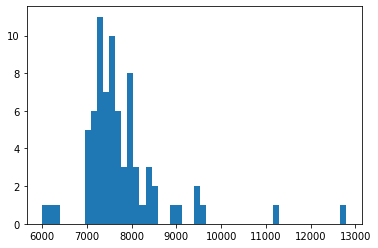

In [10]:
plt.hist(_l, bins=50) # plot Luminosity

### Error analysis

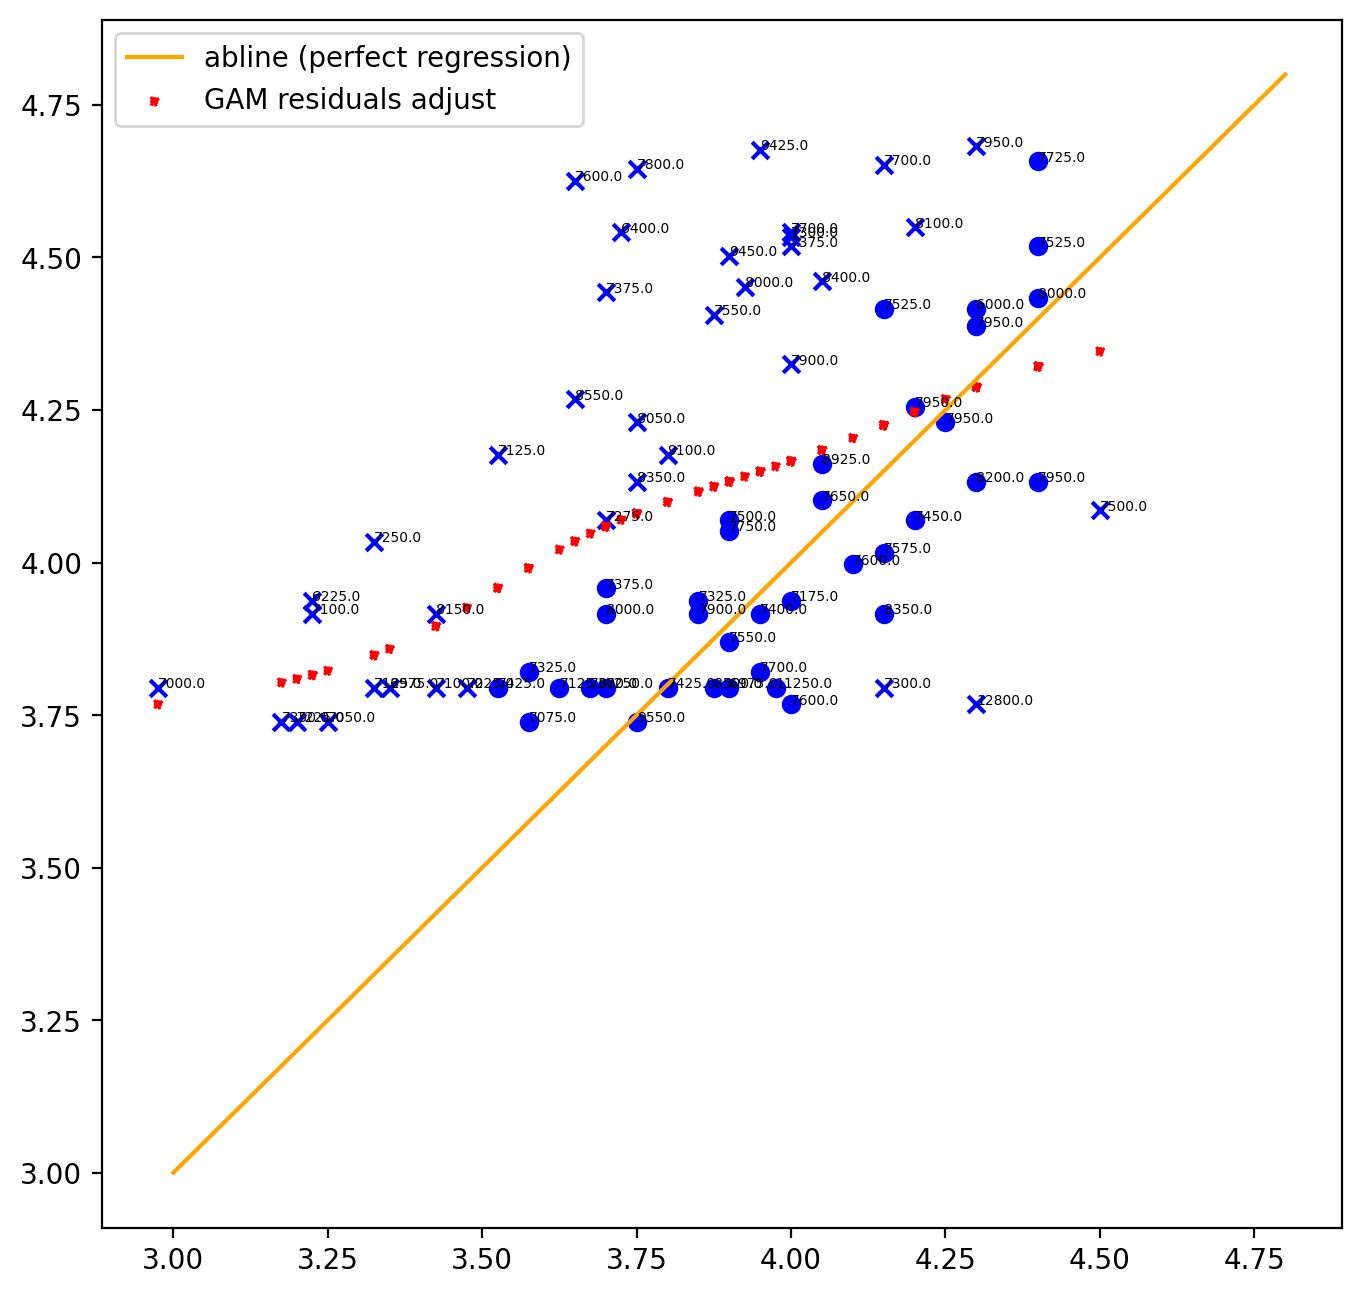

In [11]:
gam = LinearGAM(n_splines=10)
gam.fit(_x, _y)

# Scatter all "residuals"
fig = plt.subplots(1, figsize=(8, 8), dpi=200)
for i in range(len(_x)):
    if aux[i]:
        mark = "o"  # compatible
    else:
        mark = "x"  # no-compatible
    plt.scatter(_x[i], _y[i], marker=mark, color="blue")
# Plot model
plt.scatter(
    _x,
    gam.predict(_x),
    c="red",
    marker=".",
    linestyle=":",
    label="GAM residuals adjust",
)
for i, txt in enumerate(_l):
    plt.annotate(txt, (_x[i], _y[i]), size=5)

# Add abline(0,1)
x = np.linspace(3.0, 4.8, 10)
plt.plot(x, x + 0, linestyle="solid", c="orange", label="abline (perfect regression)")
plt.legend(title="")
plt.show()

In [12]:
gam = LinearGAM(n_splines=10)
gam.fit(_x, _y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.1114
Link Function:                     IdentityLink Log Likelihood:                                  -339.1801
Number of Samples:                           75 AIC:                                              690.5831
                                                AICc:                                             691.8634
                                                GCV:                                                0.0857
                                                Scale:                                              0.0753
                                                Pseudo R-Squared:                                   0.2355
Feature Function                  Lam